# Growth Limiation - Create a grid of factor most limiting growth at each year for summer months, for each phytoplankton group... throuhout a few locations of the Arctic Ocean. This should go along with the seasonal succession plot to be able to understand more clarely what is happening between these two different sectors. 
1. Target two locations that show strong interannual differences in TL, or biomass. 
2. Plot the factor most limiting growth at each one of these grid cells. 
3. Plot the anomalies in temperature, light and ice fraction for each of these grid cells

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
#import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy

In [2]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob.glob(f'{path}/*.nc', recursive=True),key=numericalSort)
ds= xr.open_mfdataset(files,combine='by_coords')

In [5]:
file = '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/growth_lim'
diat3_ind = xr.open_mfdataset(f'{file}/diat3_lim_index_remap.nc', decode_times=False)
pp_ind = xr.open_mfdataset(f'{file}/pp_lim_index_remap.nc',decode_times=False)
diat2_ind = xr.open_mfdataset(f'{file}/diat2_lim_index_remap.nc',decode_times=False)
diat1_ind = xr.open_mfdataset(f'{file}/diat1_lim_index_remap.nc',decode_times=False)
mp1_ind = xr.open_mfdataset(f'{file}/mp1_lim_index_remap.nc',decode_times=False)
mp2_ind = xr.open_mfdataset(f'{file}/mp2_lim_index_remap.nc',decode_times=False)
mp3_ind = xr.open_mfdataset(f'{file}/mp3_lim_index_remap.nc',decode_times=False)
mp4_ind = xr.open_mfdataset(f'{file}/mp4_lim_index_remap.nc',decode_times=False)

In [6]:
diat3_val = xr.open_mfdataset(f'{file}/diat3_lim_value_remap.nc', decode_times=False)
pp_val = xr.open_mfdataset(f'{file}/pp_lim_value_remap.nc',decode_times=False)
diat2_val = xr.open_mfdataset(f'{file}/diat2_lim_value_remap.nc',decode_times=False)
diat1_val = xr.open_mfdataset(f'{file}/diat1_lim_value_remap.nc',decode_times=False)
mp1_val = xr.open_mfdataset(f'{file}/mp1_lim_value_remap.nc',decode_times=False)
mp2_val = xr.open_mfdataset(f'{file}/mp2_lim_value_remap.nc',decode_times=False)
mp3_val = xr.open_mfdataset(f'{file}/mp3_lim_value_remap.nc',decode_times=False)
mp4_val = xr.open_mfdataset(f'{file}/mp4_lim_value_remap.nc',decode_times=False)

In [7]:
diat3_val.diat3_lim_value

<xarray.DataArray 'diat3_lim_value' (time: 63, month: 12, lat: 180, lon: 360)>
dask.array<open_dataset-diat3_lim_value, shape=(63, 12, 180, 360), dtype=float64, chunksize=(63, 12, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * month    (month) float64 2.266e+04 2.269e+04 2.272e+04 ... 2.296e+04 2.3e+04
Attributes:
    long_name:  diatom 3 maximum limitation value, carbon biomass weighted av...

## Set up colorbar

In [8]:
# colors for each variable 
# temperature (Blue)
temperature3 = ''
temperature        = '#e0f3f8'
temperature1       = '#abd9e9'
temperature2       = '#74add1'
# light (yellow)
light2   = '#fdae61'
light1   ='#fee090'
light   ='#ffffbf'
light3=''
# nutrients (Green)
nitrate     = '#AFE1AF'
nitrate1     ='#00A36C'
nitrate2     ='#097969'

from matplotlib.colors import LinearSegmentedColormap
color_temp = [temperature,temperature1,temperature2]
color_light = [light,light1,light2]
color_nutrients = [nitrate,nitrate1,nitrate2]

cmap_name = 'my_list'
cm_temp = LinearSegmentedColormap.from_list(
        cmap_name, color_temp, N=3)
cm_light = LinearSegmentedColormap.from_list(
        cmap_name, color_light, N=3)
cm_nutrients = LinearSegmentedColormap.from_list(
        cmap_name, color_nutrients, N=3)

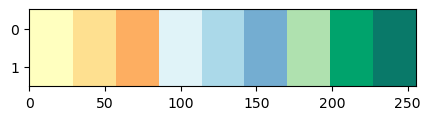

In [9]:
N = 3 # number of colors to extract from each of the base_cmaps below
phyto = [cm_light,cm_temp,cm_nutrients]

n_base = len(phyto)
# we go from 0.2 to 0.8 below to avoid having several whites and blacks in the resulting cmaps
colors_phyto = np.concatenate([plt.get_cmap(name)(np.linspace(0,1,N)) for name in phyto])
cm_phyto = mpl.colors.ListedColormap(colors_phyto)

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(1,1,figsize=(5,1))
ax.imshow(gradient, aspect='auto', cmap=cm_phyto)

In [10]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0.9994925028835063, 0.9192618223760093, 0.6061361014994233),(0.45066769191336664, 0.7509983339741125, 0.7703857490708702),(0.6825187635707243, 0.810691907283208, 0.6352470180118206)]

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=3)

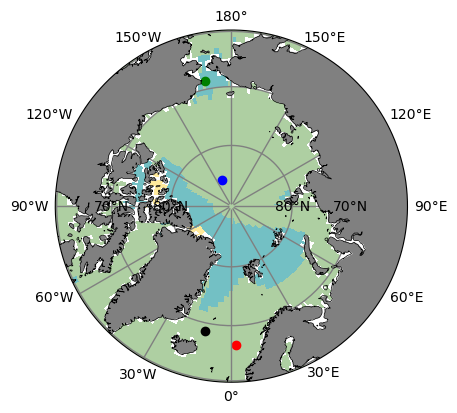

In [11]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
from cartopy.util import add_cyclic_point

r_limit = 3214068.5 #from: ax.get_ylim() of above plot
lonlatproj = ccrs.PlateCarree()
my_projn = ccrs.Orthographic(central_longitude=0, central_latitude=90)
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,
                           circle_path.codes.copy())
r_extent = r_limit*1.0001
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 2, 1, projection=my_projn) 
diat3_lims = (diat3_val.diat3_lim_value.where(diat3_val.diat3_lim_value < 0.9) + diat3_ind.diat3_lim_index.where(diat3_val.diat3_lim_value < 0.9))
summer, lon = add_cyclic_point(np.nanmean(diat3_lims[:,5:8,:,:], axis=(0,1)), coord=diat3_val.lon, axis=1)
x, y = np.meshgrid(lon,diat3_val.lat)
cff = ax.pcolormesh(x,y,summer,cmap=cm,transform=lonlatproj, vmin=0, vmax=3)


x1, y1 = np.meshgrid(diat3_val.lon[348],diat3_val.lat[158])
ax.plot(x1,y1,'o',color='k',transform=lonlatproj)

x1, y1 = np.meshgrid(diat3_val.lon[2],diat3_val.lat[156])
ax.plot(x1,y1,'o',color='r',transform=lonlatproj)

x1, y1 = np.meshgrid(diat3_val.lon[200],diat3_val.lat[175])
ax.plot(x1,y1,'o',color='b',transform=lonlatproj)

x1, y1 = np.meshgrid(diat3_val.lon[192],diat3_val.lat[158])
ax.plot(x1,y1,'o',color='g',transform=lonlatproj)

ax.coastlines(lw=0.5, color="black", zorder=20)
gls = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), lw=1, color="gray",
        y_inline=True, xlocs=range(-180,180,30), ylocs=range(-80,91,10))
ax.set_xlim(-r_extent, r_extent)
ax.set_ylim(-r_extent, r_extent)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_boundary(circle_path)
plt.show()

## Find the lons and lats for each of the regions
1. Black dot = Western Nordic Region (near greenland) `[68.5$^o$N,348$^o$E]`
2. red dot = Eastern Nordic Region `[66.5$^o$N,2$^o$E]`
3. Blue dot = Central Arctic `[85.5$^o$N, 200$^o$E]`

## Plot the regional limitaiton during the summer to make sure these are working correctly! 

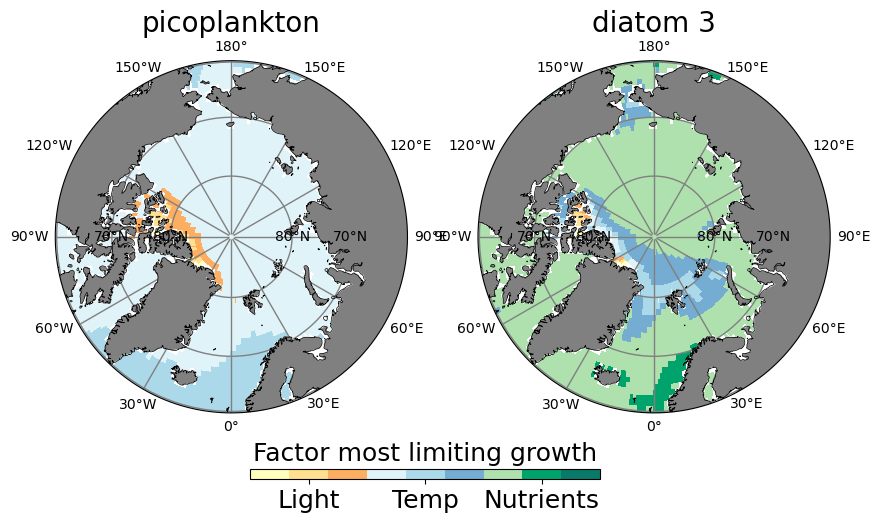

CPU times: user 6.57 s, sys: 3.56 s, total: 10.1 s
Wall time: 10.9 s


<Figure size 640x480 with 0 Axes>

In [18]:
%%time
r_limit = 3214068.5 #from: ax.get_ylim() of above plot
lonlatproj = ccrs.PlateCarree()
my_projn = ccrs.Orthographic(central_longitude=0, central_latitude=90)
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,
                           circle_path.codes.copy())
r_extent = r_limit*1.0001
fig = plt.figure(figsize=(10,5))
# ------------------------- Picoplankton ---------------------------
# Summer
ax = fig.add_subplot(1, 2, 1, projection=my_projn) 
ax.set_title("picoplankton",fontsize=20)
pp_lims = (pp_val.pp_lim_value.where(pp_val.pp_lim_value < 0.9) + pp_ind.pp_lim_index.where(pp_val.pp_lim_value < 0.9))
summer, lon = add_cyclic_point(np.nanmean(pp_lims[:,5:8,:,:], axis=(0,1)), coord=diat3_val.lon, axis=1)
x, y = np.meshgrid(lon,diat3_val.lat)
cf = ax.pcolormesh(x,y,summer,cmap=cm_phyto,transform=lonlatproj, vmin=0, vmax=3)
ax.coastlines(lw=0.5, color="black", zorder=20)
gls = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), lw=1, color="gray",
        y_inline=True, xlocs=range(-180,180,30), ylocs=range(-80,91,10))
ax.set_xlim(-r_extent, r_extent)
ax.set_ylim(-r_extent, r_extent)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_boundary(circle_path)

# ------------------------- Diatom 3 ---------------------------
# Summer
ax = fig.add_subplot(1, 2, 2, projection=my_projn) 
ax.set_title("diatom 3",fontsize=20)
diat3_lims = (diat3_val.diat3_lim_value.where(diat3_val.diat3_lim_value < 0.9) + diat3_ind.diat3_lim_index.where(diat3_val.diat3_lim_value < 0.9))
summer, lon = add_cyclic_point(np.nanmean(diat3_lims[:,5:8,:,:], axis=(0,1)), coord=diat3_val.lon, axis=1)
x, y = np.meshgrid(lon,diat3_val.lat)
cff = ax.pcolormesh(x,y,summer,cmap=cm_phyto,transform=lonlatproj, vmin=0, vmax=3)
ax.coastlines(lw=0.5, color="black", zorder=20)
gls = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), lw=1, color="gray",
        y_inline=True, xlocs=range(-180,180,30), ylocs=range(-80,91,10))
ax.set_xlim(-r_extent, r_extent)
ax.set_ylim(-r_extent, r_extent)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_boundary(circle_path)

cbar_ax = fig.add_axes([0.32, 0.01, 0.35, 0.02])
cbar = fig.colorbar(cf, cax=cbar_ax, shrink=0.75, spacing='uniform',ticks=[0.5,1.5,2.5],orientation="horizontal")
cbar.ax.set_xticklabels(['Light','Temp', 'Nutrients'], fontsize = 18)
cbar.ax.set_title('Factor most limiting growth', fontsize = 18)
plt.show()
plt.tight_layout()
region = 'ao'
season = 'summer'
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_limitation.png', dpi=600, bbox_inches='tight')

### This confirms that it does show the same trends as it does the none 1 degree grid

In [12]:
%%time
pp_lims = (pp_val.pp_lim_value.where(pp_val.pp_lim_value < 0.9) + pp_ind.pp_lim_index.where(pp_val.pp_lim_value < 0.9))
mp1_lims = (mp1_val.mp1_lim_value.where(mp1_val.mp1_lim_value < 0.9) + mp1_ind.mp1_lim_index.where(mp1_val.mp1_lim_value < 0.9))
mp2_lims = (mp2_val.mp2_lim_value.where(mp2_val.mp2_lim_value < 0.9) + mp2_ind.mp2_lim_index.where(mp2_val.mp2_lim_value < 0.9))
mp3_lims = (mp3_val.mp3_lim_value.where(mp3_val.mp3_lim_value < 0.9) + mp3_ind.mp3_lim_index.where(mp3_val.mp3_lim_value < 0.9))
mp4_lims = (mp4_val.mp4_lim_value.where(mp4_val.mp4_lim_value < 0.9) + mp4_ind.mp4_lim_index.where(mp4_val.mp4_lim_value < 0.9))
diat1_lims = (diat1_val.diat1_lim_value.where(diat1_val.diat1_lim_value < 0.9) + diat1_ind.diat1_lim_index.where(diat1_val.diat1_lim_value < 0.9))
diat2_lims = (diat2_val.diat2_lim_value.where(diat2_val.diat2_lim_value < 0.9) + diat2_ind.diat2_lim_index.where(diat2_val.diat2_lim_value < 0.9))
diat3_lims = (diat3_val.diat3_lim_value.where(diat3_val.diat3_lim_value < 0.9) + diat3_ind.diat3_lim_index.where(diat3_val.diat3_lim_value < 0.9))

CPU times: user 69.4 ms, sys: 0 ns, total: 69.4 ms
Wall time: 76.7 ms


In [13]:
%%time
phyto_lims_summer = np.stack([np.nanmean(pp_lims[:,5:8,:,:],axis=1),
                       np.nanmean(mp1_lims[:,5:8,:,:],axis=1),
                       np.nanmean(diat1_lims[:,5:8,:,:],axis=1),
                       np.nanmean(mp2_lims[:,5:8,:,:],axis=1),
                       np.nanmean(diat2_lims[:,5:8,:,:],axis=1),
                       np.nanmean(mp3_lims[:,5:8,:,:],axis=1),
                       np.nanmean(diat3_lims[:,5:8,:,:],axis=1),
                       np.nanmean(mp4_lims[:,5:8,:,:],axis=1)
                      ],axis=0)

CPU times: user 3.24 s, sys: 6.92 s, total: 10.2 s
Wall time: 11.2 s


In [14]:
%%time
phyto_lims_fall = np.stack([np.nanmean(pp_lims[:,8:11,:,:],axis=1),
                       np.nanmean(mp1_lims[:,8:11,:,:],axis=1),
                       np.nanmean(diat1_lims[:,8:11,:,:],axis=1),
                       np.nanmean(mp2_lims[:,8:11,:,:],axis=1),
                       np.nanmean(diat2_lims[:,8:11,:,:],axis=1),
                       np.nanmean(mp3_lims[:,8:11,:,:],axis=1),
                       np.nanmean(diat3_lims[:,8:11,:,:],axis=1),
                       np.nanmean(mp4_lims[:,8:11,:,:],axis=1)
                      ],axis=0)

CPU times: user 3.2 s, sys: 4.62 s, total: 7.81 s
Wall time: 8.02 s


In [15]:
%%time
phyto_lims_spring = np.stack([np.nanmean(pp_lims[:,2:5,:,:],axis=1),
                       np.nanmean(mp1_lims[:,2:5,:,:],axis=1),
                       np.nanmean(diat1_lims[:,2:5,:,:],axis=1),
                       np.nanmean(mp2_lims[:,2:5,:,:],axis=1),
                       np.nanmean(diat2_lims[:,2:5,:,:],axis=1),
                       np.nanmean(mp3_lims[:,2:5,:,:],axis=1),
                       np.nanmean(diat3_lims[:,2:5,:,:],axis=1),
                       np.nanmean(mp4_lims[:,2:5,:,:],axis=1)
                      ],axis=0)

CPU times: user 3.2 s, sys: 4.76 s, total: 7.96 s
Wall time: 8.15 s


In [16]:
%%time
phyto_lims_winter = np.stack([np.nanmean(pp_lims[:,list(range(2)) + [-1],:,:],axis=1),
                       np.nanmean(mp1_lims[:,list(range(2)) + [-1],:,:],axis=1),
                       np.nanmean(diat1_lims[:,list(range(2)) + [-1],:,:],axis=1),
                       np.nanmean(mp2_lims[:,list(range(2)) + [-1],:,:],axis=1),
                       np.nanmean(diat2_lims[:,list(range(2)) + [-1],:,:],axis=1),
                       np.nanmean(mp3_lims[:,list(range(2)) + [-1],:,:],axis=1),
                       np.nanmean(diat3_lims[:,list(range(2)) + [-1],:,:],axis=1),
                       np.nanmean(mp4_lims[:,list(range(2)) + [-1],:,:],axis=1)
                      ],axis=0)

CPU times: user 3.21 s, sys: 4.76 s, total: 7.97 s
Wall time: 8.18 s


## Create colormap with three different colors, representing temperature, light and nutrients. 

In [17]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0.9994925028835063, 0.9192618223760093, 0.6061361014994233),
          (0.45066769191336664, 0.7509983339741125, 0.7703857490708702),
          (0.6825187635707243, 0.810691907283208, 0.6352470180118206)]

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=3)

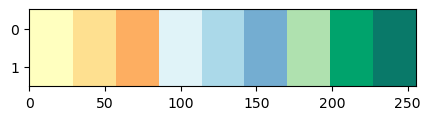

In [18]:
N = 3 # number of colors to extract from each of the base_cmaps below
phyto = [cm_light,cm_temp,cm_nutrients]

n_base = len(phyto)
# we go from 0.2 to 0.8 below to avoid having several whites and blacks in the resulting cmaps
colors_phyto = np.concatenate([plt.get_cmap(name)(np.linspace(0,1,N)) for name in phyto])
cm_phyto = mpl.colors.ListedColormap(colors_phyto)

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(1,1,figsize=(5,1))
ax.imshow(gradient, aspect='auto', cmap=cm_phyto)

## Create grid, with phytoplankton types in the y axis, and years in the x axis, that are color coded with the most limiting factor. 

In [19]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

In [20]:
years = ['1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']

1. Western Nordic Sea = `diat3_val.lon[348]`, `diat3_val.lat[158]`
    - Black dot = Western Nordic Region (near greenland) `[68.5$^o$N,348$^o$E]`

2. Eastern Nordic Sea = `diat3_val.lon[2]`,`diat3_val.lat[156]`
    - red dot = Eastern Nordic Region `[66.5$^o$N,2$^o$E]`

3. Central Arctic Ocean  = `diat3_val.lon[200]`,`diat3_val.lat[175]`
    - Blue dot = Central Arctic `[85.5$^o$N, 200$^o$E]`
    
4. Chukchi Sea = = `diat3_val.lon[192]`,`diat3_val.lat[158]`
    - Green dot = Chukchi Sea `[68.5$^o$N, 192$^o$E]`, or `[68.5$^o$N, 168$^o$W]`


In [21]:
diat3_val.lon[192]-360

<xarray.DataArray 'lon' ()>
array(-168.)
Coordinates:
    lon      float64 192.0

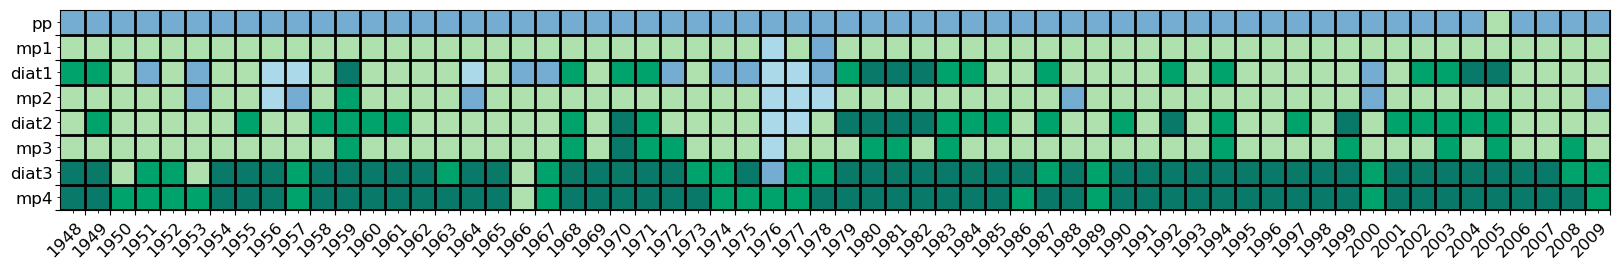

In [28]:
data =  phyto_lims_summer[:,0:62,158,192] # Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto, vmin=0,vmax=2)


# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)
#ax.set_title('Summer, Chukchi Sea [68.5$^o$N,348$^o$E]')

plt.show()
region = 'ao_g'
season = 'summer'
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_grid.png', dpi=600, bbox_inches='tight')

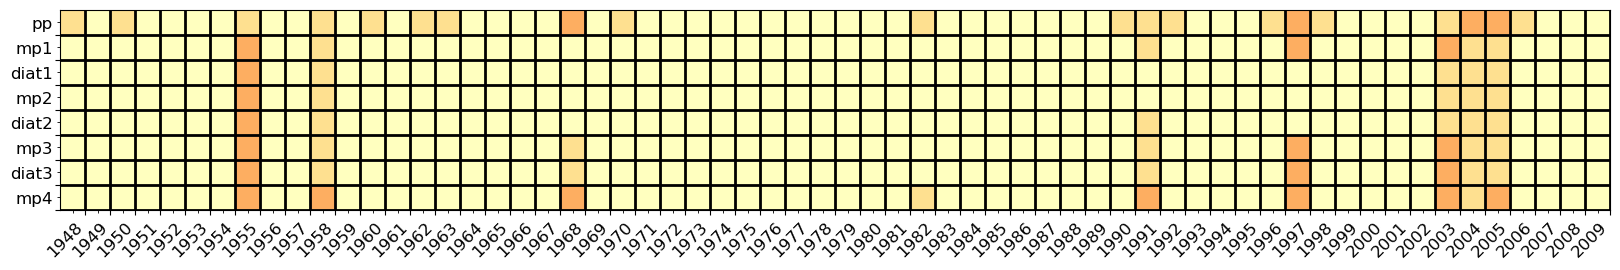

In [26]:
data =  phyto_lims_spring[:,0:62,158,192] # Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto, vmin=0,vmax=2)


# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)
#ax.set_title('Spring, Chukchi Sea [68.5$^o$N,348$^o$E]')

plt.show()
region = 'ao_g'
season = 'spring'
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_grid.png', dpi=600, bbox_inches='tight')

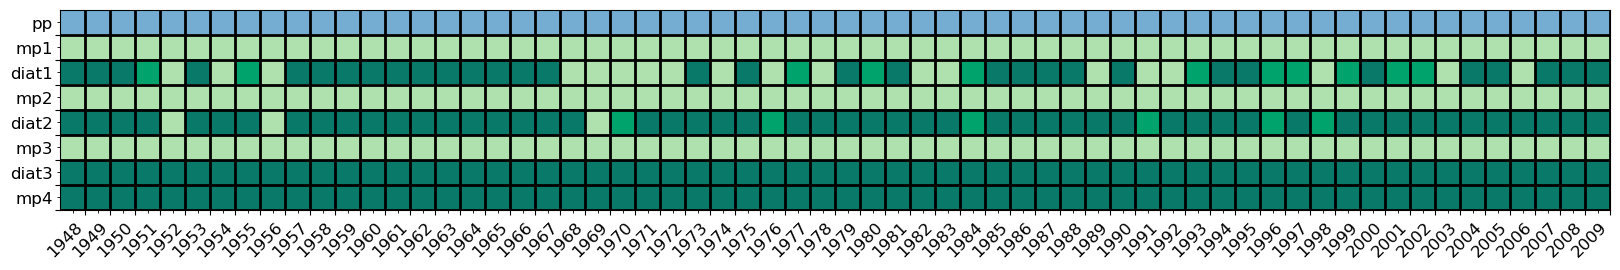

In [23]:
data =  phyto_lims_summer[:,0:62,158,348] # Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto, vmin=0,vmax=2)


# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)
#ax.set_title('Summer, Western Nordic Region [68.5$^o$N,348$^o$E]')

plt.show()
region = 'ao_k'
season = 'summer'
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_grid.png', dpi=600, bbox_inches='tight')

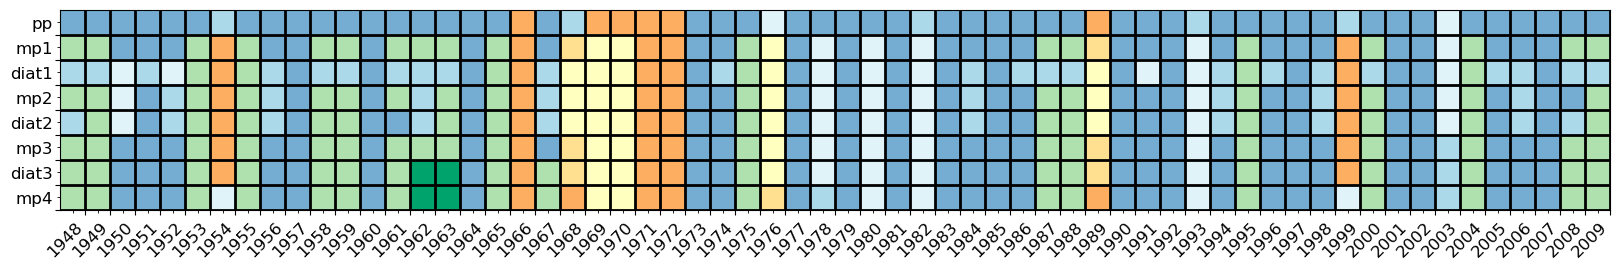

In [24]:
data =  phyto_lims_spring[:,0:62,158,348] # Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto, vmin=0,vmax=2)


# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)
#ax.set_title('Spring, Western Nordic Region [68.5$^o$N,348$^o$E]')

plt.show()
region = 'ao_k'
season = 'spring'
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_grid.png', dpi=600, bbox_inches='tight')

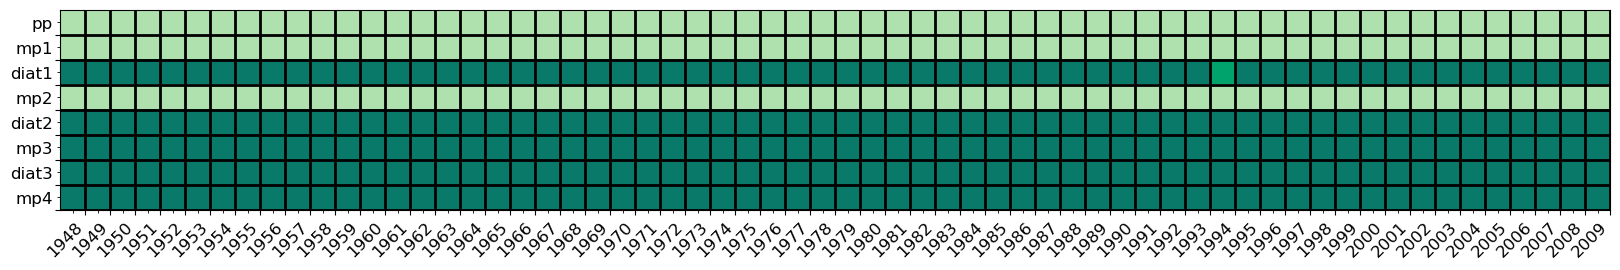

In [25]:
data =  phyto_lims_summer[:,0:62,156,2] # Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto, vmin=0,vmax=2)


# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)
#ax.set_title('Summer, Eastern Nordic Region [66.5$^o$N,2$^o$E]')

plt.show()
region = 'ao_r'
season = 'summer'
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_grid.png', dpi=600, bbox_inches='tight')

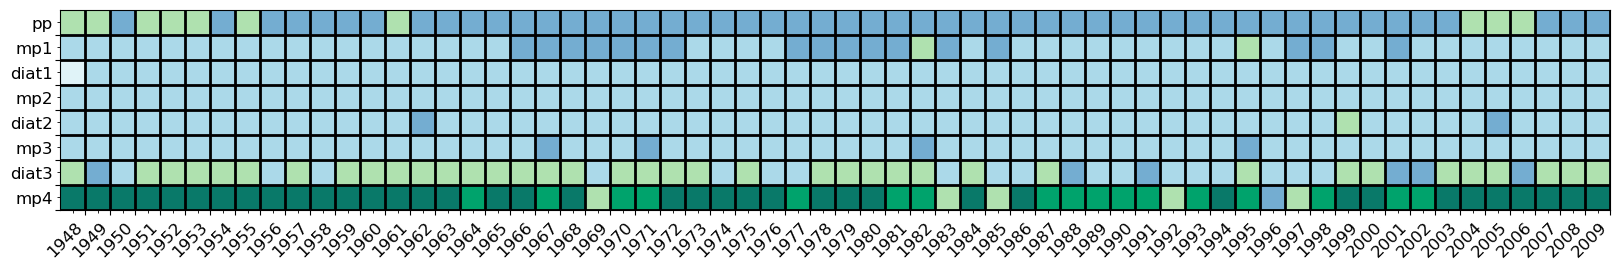

In [26]:
data =  phyto_lims_spring[:,0:62,156,2] # Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto, vmin=0,vmax=2)


# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)
#ax.set_title('Spring, Eastern Nordic Region [66.5$^o$N,2$^o$E]')

plt.show()
region = 'ao_r'
season = 'spring'
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_grid.png', dpi=600, bbox_inches='tight')

## Central Arctic Ocean 

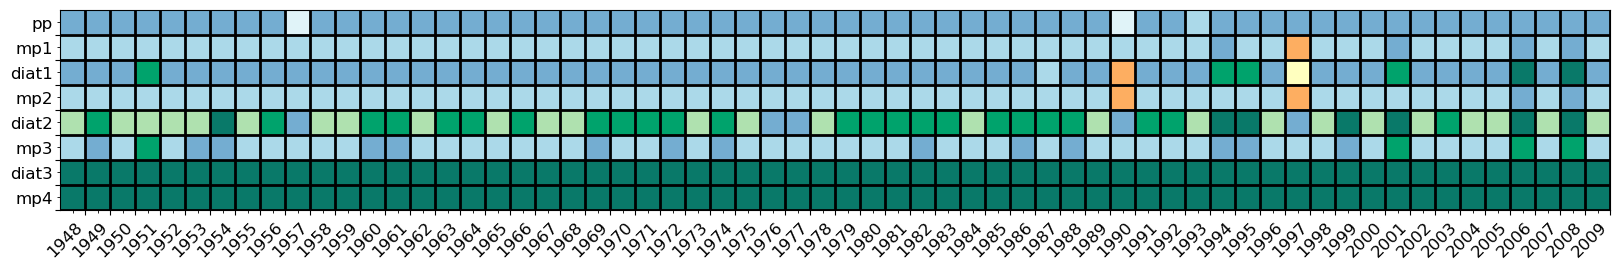

In [27]:
data =  phyto_lims_summer[:,0:62,175,200] # Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto,vmin=0,vmax=2)


# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)
#ax.set_title('Summer, Central Arctic Ocean [85.5$^o$N, 200$^o$E]')

plt.show()
region = 'ao_b'
season = 'summer'
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_grid.png', dpi=600, bbox_inches='tight')

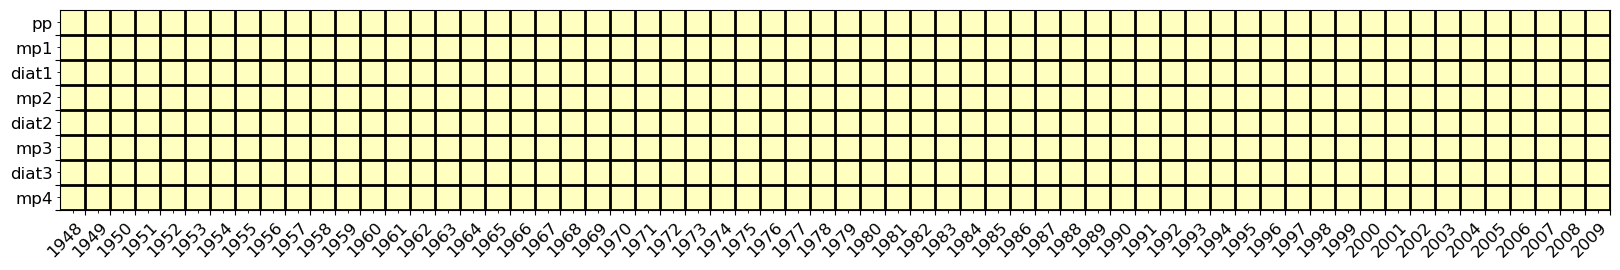

In [28]:
data =  phyto_lims_spring[:,0:62,175,200] # Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto,vmin=0,vmax=2)


# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)
#ax.set_title('Spring, Central Arctic Ocean [85.5$^o$N, 200$^o$E]')

plt.show()
region = 'ao_b'
season = 'spring'
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_grid.png', dpi=600, bbox_inches='tight')

## Whole Arctic Ocean

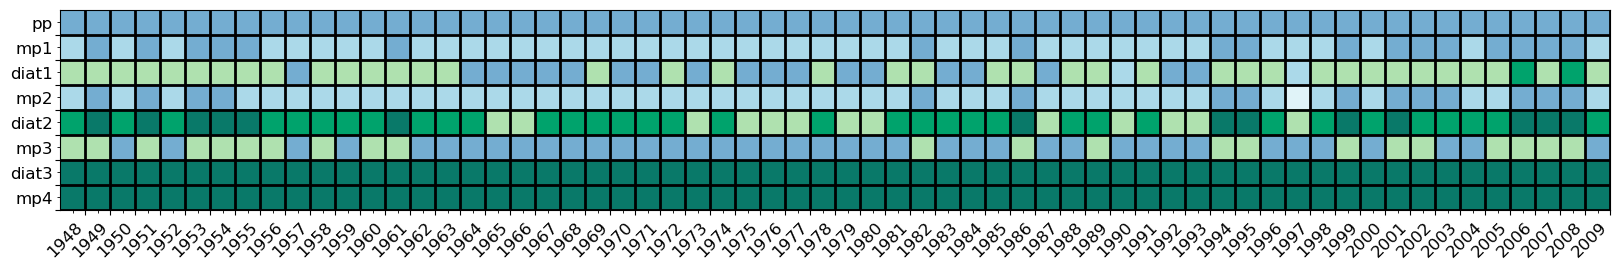

In [32]:
region = 'whole_arctic_ocean'
season = 'summer'
data =  np.nanmean(phyto_lims_summer[:,0:62,149:180,:],axis=(2,3))# Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto,vmin=0,vmax=2)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)

plt.show()
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}whole_{region}_{season}.png', dpi=600, bbox_inches='tight')

## Import the phytoplankton biomass (mmol m-3) averaged through the top 150m

In [22]:
# Units should be mmol m-3 (averaged through the top 150m)
path = '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009/regrid/regrid_pbmss_ch2_1948_2009_'
ppC = xr.open_mfdataset(f'{path}ppC.nc') # mmol m-3
mp1C = xr.open_mfdataset(f'{path}mp1C.nc')# mmol m-3
mp2C = xr.open_mfdataset(f'{path}mp2C.nc')# mmol m-3
mp3C = xr.open_mfdataset(f'{path}mp3C.nc')# mmol m-3
mp4C = xr.open_mfdataset(f'{path}mp4C.nc')# mmol m-3
diat1C = xr.open_mfdataset(f'{path}diat1C.nc')# mmol m-3
diat2C = xr.open_mfdataset(f'{path}diat2C.nc')# mmol m-3
diat3C = xr.open_mfdataset(f'{path}diat3C.nc')# mmol m-3
diazC = xr.open_mfdataset(f'{path}diazC.nc')# mmol m-3
photoC_TOT = xr.open_mfdataset(f'{path}photoC_TOT.nc') # units are mmol m-3 s-1

In [23]:
%%time
bmss = np.stack([ppC.ppC_150m_zint, mp1C.mp1C, diazC.diazC, 
                   mp2C.mp2C, diat1C.diat1C, diat2C.diat2C, 
                   mp3C.mp3C, diat3C.diat3C, mp4C.mp4C]) # units of mmol m-3 (depth averaged through the top 150m)
bmss_tot = np.nansum(bmss,axis=0)

CPU times: user 1.23 s, sys: 2.24 s, total: 3.47 s
Wall time: 3.96 s


In [24]:
%%time
bmss_small = np.stack([ppC.ppC_150m_zint, mp1C.mp1C, diazC.diazC]) # units of mmol m-3 (depth averaged through the top 150m)
bmss_small_tot = np.nansum(bmss_small,axis=0)

CPU times: user 453 ms, sys: 469 ms, total: 922 ms
Wall time: 962 ms


In [25]:
%%time
bmss_med = np.stack([mp2C.mp2C, diat1C.diat1C]) # units of mmol m-3 (depth averaged through the top 150m)
bmss_med_tot = np.nansum(bmss_med,axis=0)

CPU times: user 292 ms, sys: 335 ms, total: 627 ms
Wall time: 649 ms


In [26]:
%%time
bmss_large = np.stack([diat2C.diat2C, 
                   mp3C.mp3C, diat3C.diat3C, mp4C.mp4C]) # units of mmol m-3 (depth averaged through the top 150m)
bmss_large_tot = np.nansum(bmss_large,axis=0)

CPU times: user 597 ms, sys: 605 ms, total: 1.2 s
Wall time: 1.22 s


# Now plot out all of the anomalies

In [27]:
%%time
temp_inds = sorted(glob.glob('/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_TEMP*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

CPU times: user 573 ms, sys: 339 ms, total: 912 ms
Wall time: 9.77 s


In [28]:
%%time
temp_ds_inter = np.empty([63,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    temp_ds_inter[i,:,:,:] = ds.TEMP[x[i]:x[i]+12,0,:,:]

CPU times: user 530 ms, sys: 2.51 s, total: 3.04 s
Wall time: 11.6 s


In [29]:
%%time
temp_inds = sorted(glob.glob('/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_ECOSYS_IFRAC*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

CPU times: user 468 ms, sys: 166 ms, total: 634 ms
Wall time: 2.01 s


In [30]:
%%time
ECOSYS_IFRAC_ds_inter = np.empty([63,12,180,360])
ECOSYS_IFRAC_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    ECOSYS_IFRAC_ds_inter[i,:,:,:] = ds.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

CPU times: user 476 ms, sys: 87.3 ms, total: 564 ms
Wall time: 584 ms


In [31]:
%%time
NO3_inds = sorted(glob.glob('/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_NO3*.nc', recursive=True))
ds= xr.open_mfdataset(NO3_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

CPU times: user 557 ms, sys: 272 ms, total: 829 ms
Wall time: 9.9 s


In [32]:
%%time
NO3_ds_inter = np.empty([63,12,180,360])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    NO3_ds_inter[i,:,:,:] = ds.NO3[x[i]:x[i]+12,0,:,:]

CPU times: user 545 ms, sys: 2.66 s, total: 3.21 s
Wall time: 12.4 s


In [33]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec

## The latitudes and longitudes in these are different. the longitude in limitation values goes from 0-360 E, and the longitude in the individual values goes from -180 to 180 E

1. Western Nordic Sea = `diat3_val.lon[348]`, `diat3_val.lat[158]`
    - Black dot = Western Nordic Region (near greenland) `[68.5$^o$N,348$^o$E]`
    - - `ds.lon[168]`, `ds.lat[158]`, `[68.5$^o$N,12$^o$W]`

2. Eastern Nordic Sea = `diat3_val.lon[2]`,`diat3_val.lat[156]`
    - red dot = Eastern Nordic Region `[66.5$^o$N,2$^o$E]`
    - - `ds.lon[182]`, `ds.lat[156]`, `[66.5$^o$N,2$^o$E]`

3. Central Arctic Ocean  = `diat3_val.lon[200]`,`diat3_val.lat[175]`
    - Blue dot = Central Arctic `[85.5$^o$N, 200$^o$E]`
    - - `ds.lon[20]`, `ds.lat[175]`, `[85.5$^o$N,160$^o$W]`
    
4. Chukchi Sea = = `diat3_val.lon[192]`,`diat3_val.lat[158]`
    - Green dot = Chukchi Sea `[68.5$^o$N, 192$^o$E]`, or `[68.5$^o$N, 168$^o$W]`
    - - `ds.lon[12]`, `ds.lat[158]`, `[68.5$^o$N, 168$^o$W]`

In [33]:
ds.lon[12]

<xarray.DataArray 'lon' ()>
array(-168.)
Coordinates:
    lon      float64 -168.0
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

# Annomaly plots in the summer

In [70]:
temp_ao_b_anom = temp_ds_inter[0:62,5:8,175,20]-np.nanmean(temp_ds_inter[0:62,5:8,175,20],axis=0)
temp_ao_k_anom = temp_ds_inter[0:62,5:8,158,168]-np.nanmean(temp_ds_inter[0:62,5:8,158,168],axis=0)
temp_ao_r_anom = temp_ds_inter[0:62,5:8,156,182]-np.nanmean(temp_ds_inter[0:62,5:8,156,182],axis=0)
temp_ao_g_anom = temp_ds_inter[0:62,5:8,158,12]-np.nanmean(temp_ds_inter[0:62,5:8,158,12],axis=0)

NO3_ao_b_anom = NO3_ds_inter[0:62,5:8,175,20]-np.nanmean(NO3_ds_inter[0:62,5:8,175,20],axis=0)
NO3_ao_k_anom = NO3_ds_inter[0:62,5:8,158,168]-np.nanmean(NO3_ds_inter[0:62,5:8,158,168],axis=0)
NO3_ao_r_anom = NO3_ds_inter[0:62,5:8,156,182]-np.nanmean(NO3_ds_inter[0:62,5:8,156,182],axis=0)
NO3_ao_g_anom = NO3_ds_inter[0:62,5:8,158,12]-np.nanmean(NO3_ds_inter[0:62,5:8,158,12],axis=0)

bmss_ao_b_anom = bmss_tot[:,5:8,175,20]-np.nanmean(bmss_tot[:,5:8,175,20],axis=0)
bmss_ao_k_anom = bmss_tot[:,5:8,158,168]-np.nanmean(bmss_tot[:,5:8,158,168],axis=0)
bmss_ao_r_anom = bmss_tot[:,5:8,156,182]-np.nanmean(bmss_tot[:,5:8,156,182],axis=0)
bmss_ao_g_anom = bmss_tot[:,5:8,158,12]-np.nanmean(bmss_tot[:,5:8,158,12],axis=0)

bmss_small_ao_b_anom = bmss_small_tot[:,5:8,175,20]-np.nanmean(bmss_small_tot[:,5:8,175,20],axis=0)
bmss_small_ao_k_anom = bmss_small_tot[:,5:8,158,168]-np.nanmean(bmss_small_tot[:,5:8,158,168],axis=0)
bmss_small_ao_r_anom = bmss_small_tot[:,5:8,156,182]-np.nanmean(bmss_small_tot[:,5:8,156,182],axis=0)
bmss_small_ao_g_anom = bmss_small_tot[:,5:8,158,12]-np.nanmean(bmss_small_tot[:,5:8,158,12],axis=0)

bmss_med_ao_b_anom = bmss_med_tot[:,5:8,175,20]-np.nanmean(bmss_med_tot[:,5:8,175,20],axis=0)
bmss_med_ao_k_anom = bmss_med_tot[:,5:8,158,168]-np.nanmean(bmss_med_tot[:,5:8,158,168],axis=0)
bmss_med_ao_r_anom = bmss_med_tot[:,5:8,156,182]-np.nanmean(bmss_med_tot[:,5:8,156,182],axis=0)
bmss_med_ao_g_anom = bmss_med_tot[:,5:8,158,12]-np.nanmean(bmss_med_tot[:,5:8,158,12],axis=0)

bmss_large_ao_b_anom = bmss_large_tot[:,5:8,175,20]-np.nanmean(bmss_large_tot[:,5:8,175,20],axis=0)
bmss_large_ao_k_anom = bmss_large_tot[:,5:8,158,168]-np.nanmean(bmss_large_tot[:,5:8,158,168],axis=0)
bmss_large_ao_r_anom = bmss_large_tot[:,5:8,156,182]-np.nanmean(bmss_large_tot[:,5:8,156,182],axis=0)
bmss_large_ao_g_anom = bmss_large_tot[:,5:8,158,12]-np.nanmean(bmss_large_tot[:,5:8,158,12],axis=0)

ECOSYS_IFRAC_ao_b_anom = ECOSYS_IFRAC_ds_inter[0:62,5:8,175,20]-np.nanmean(ECOSYS_IFRAC_ds_inter[0:62,5:8,175,20],axis=0)
ECOSYS_IFRAC_ao_k_anom = ECOSYS_IFRAC_ds_inter[0:62,5:8,158,168]-np.nanmean(ECOSYS_IFRAC_ds_inter[0:62,5:8,158,168],axis=0)
ECOSYS_IFRAC_ao_r_anom = ECOSYS_IFRAC_ds_inter[0:62,5:8,156,182]-np.nanmean(ECOSYS_IFRAC_ds_inter[0:62,5:8,156,182],axis=0)
ECOSYS_IFRAC_ao_g_anom = ECOSYS_IFRAC_ds_inter[0:62,5:8,158,12]-np.nanmean(ECOSYS_IFRAC_ds_inter[0:62,5:8,158,12],axis=0)

In [71]:
temp_ds_inter[0:62,:,:,:].shape

(62, 12, 180, 360)

## Create a new colorbar for these new figures

In [72]:
# colors for each variable 
# temperature (Blue)
temperature        = 'cornflowerblue'
# light (yellow)
light   ='gold'
# nutrients (Green)
nitrate     = 'yellowgreen'

from matplotlib.colors import LinearSegmentedColormap
color_new = [temperature,light,nitrate]

cmap_name = 'my_list'
cm_new = LinearSegmentedColormap.from_list(
        cmap_name, color_new, N=3)

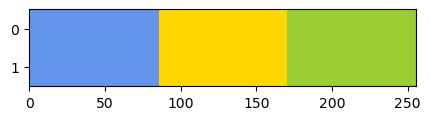

In [73]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(1,1,figsize=(5,1))
ax.imshow(gradient, aspect='auto', cmap=cm_new)

In [74]:
years = ['1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']

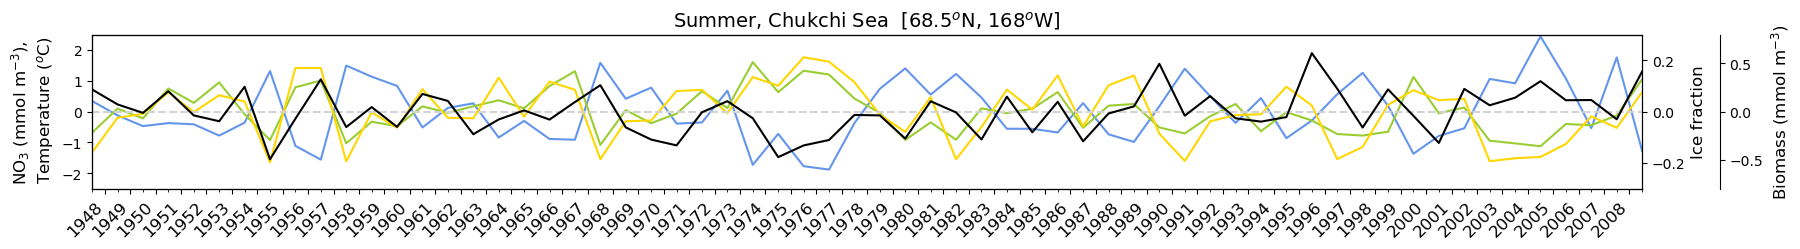

In [75]:
region = 'ao_g'
season = 'summer'
fig = plt.figure(figsize=(20, 2))
ax1 = fig.add_subplot(1,1,1);
ax2=ax1.twinx()
lsize=14
ln1 = ax1.plot(np.nanmean(temp_ao_g_anom,axis=1),color=cm_new(0),label = 'Temp')
ln2 = ax2.plot(np.nanmean(ECOSYS_IFRAC_ao_g_anom,axis=1),color=cm_new(1),label = 'Ice')
ln3 = ax1.plot(np.nanmean(NO3_ao_g_anom,axis=1), color=cm_new(2),label = 'NO$_3$')
ax1.set_title('Summer, Chukchi Sea  [68.5$^o$N, 168$^o$W]', fontsize=lsize)
ax1.set_ylim(-2.5,2.5)
ax2.set_ylabel("Ice fraction",color='k',fontsize=12)
ax1.set_ylabel("NO$_3$ (mmol m$^{-3}$), \n Temperature ($^o$C)",color="k",fontsize=12)
plt.axhline(y=0, color='lightgray', linestyle='--')
ax2.set_ylim(-0.3,0.3)
ax3=ax1.twinx(); ax3.spines['right'].set_position(("axes", 1.05))
ln4 = ax3.plot(np.nanmean(bmss_ao_g_anom,axis=1), color='k',label = 'sm Biomass')
ax3.set_ylim(-0.8,0.8)
ax3.set_ylabel("Biomass (mmol m$^{-3})$",color="k",fontsize=12)
ax1.set_xticks(np.arange(0.5, 62, 1));
ax1.set_xticks(np.arange(0, 62, 1), minor=True);
ax1.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax1.margins(x=0)
# added these three lines
#lns = ln1+ln2+ln3+ln4
#labs = [l.get_label() for l in lns]
#ax1.legend(lns, labs, loc=3,ncol=4,fontsize=12)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_anomaly_bmss.png', dpi=600, bbox_inches='tight')

## Let's create a scatter plot with all of the annomalies and see if there are any correlations. 
- phytoplankton biomass in the x axis, and temperature,ice and no3 in the y axis with different colors?

The most common threshold is p < 0.05, which means that the data is likely to occur less than 5% of the time under the null hypothesis. When the p-value falls below the chosen alpha value, then we say the result of the test is statistically significant.

In [76]:
from scipy import stats

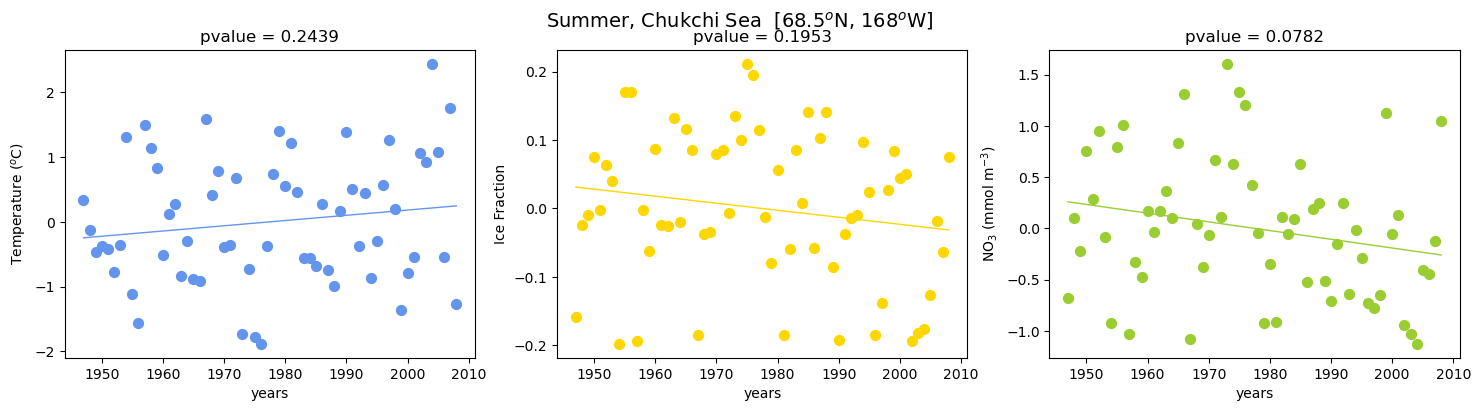

In [77]:
fig = plt.figure(figsize = (18,4))
# Separate the x and y axis
lsize=14
X1 = np.arange(1947,2009,1)
Y1 = np.nanmean(temp_ao_g_anom,axis=1)
Y2 = np.nanmean(ECOSYS_IFRAC_ao_g_anom,axis=1)
Y3 = np.nanmean(NO3_ao_g_anom,axis=1)

# Calculate statistics (temperature & time)
res1 = stats.linregress(X1, Y1)
YY1 = res1.intercept + res1.slope*X1

# Calculate statistics (Ice fraction & time)
res2 = stats.linregress(X1, Y2)
YY2 = res2.intercept + res2.slope*X1

# Calculate statistics (NO3 & time)
res3 = stats.linregress(X1, Y3)
YY3 = res3.intercept + res3.slope*X1

#Temperature & Biomass 
ax = fig.add_subplot(1,3,1)
ax.scatter(X1, Y1, color = cm_new(0), s = 50)
ax.plot(X1, YY1, color = cm_new(0), linewidth = 1, label='Temperature')
ax.set_title(f'pvalue = {res1.pvalue:.4f}')
ax.set_xlabel('years')
ax.set_ylabel('Temperature ($^o$C)')
# Ice Fraction & Biomass 
ax = fig.add_subplot(1,3,2)
ax.scatter(X1, Y2, color = cm_new(1), s = 50)
ax.plot(X1, YY2, color = cm_new(1), linewidth = 1, label='Ice Fraction')
ax.set_title(f'pvalue = {res2.pvalue:.4f}')
ax.set_xlabel('years')
ax.set_ylabel('Ice Fraction')
# NO3 & Biomass 
ax = fig.add_subplot(1,3,3)
ax.scatter(X1, Y3, color = cm_new(2), s = 50)
ax.plot(X1, YY3, color = cm_new(2), linewidth = 1, label='NO$_3$')
ax.set_title(f'pvalue = {res3.pvalue:.4f}')
ax.set_xlabel('years')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
fig.suptitle('Summer, Chukchi Sea  [68.5$^o$N, 168$^o$W]', fontsize=lsize)
region = 'ao_g'
season = 'summer'
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_pvalue_T_Ice_NO3_time.png', dpi=600, bbox_inches='tight')

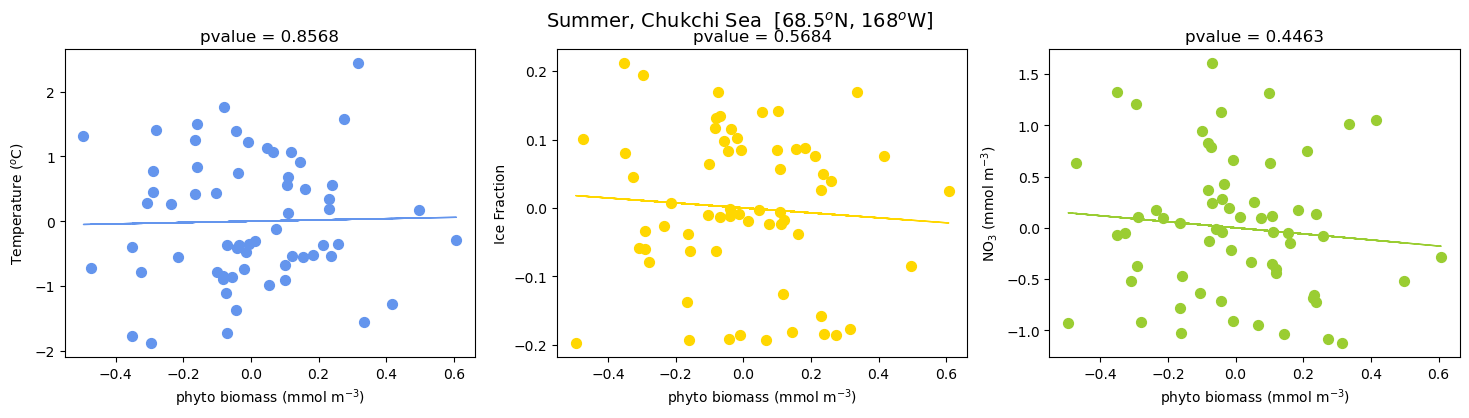

In [78]:
fig = plt.figure(figsize = (18,4))
# Separate the x and y axis
X1 = np.nanmean(bmss_ao_g_anom,axis=1)
Y1 = np.nanmean(temp_ao_g_anom,axis=1)
Y2 = np.nanmean(ECOSYS_IFRAC_ao_g_anom,axis=1)
Y3 = np.nanmean(NO3_ao_g_anom,axis=1)

# Calculate statistics (temperature & Biomass)
res1 = stats.linregress(X1, Y1)
YY1 = res1.intercept + res1.slope*X1

# Calculate statistics (Ice fraction & Biomass)
res2 = stats.linregress(X1, Y2)
YY2 = res2.intercept + res2.slope*X1

# Calculate statistics (NO3 & Biomass)
res3 = stats.linregress(X1, Y3)
YY3 = res3.intercept + res3.slope*X1

#Temperature & Biomass 
ax = fig.add_subplot(1,3,1)
ax.scatter(X1, Y1, color = cm_new(0), s = 50)
ax.plot(X1, YY1, color = cm_new(0), linewidth = 1, label='Temperature')
ax.set_title(f'pvalue = {res1.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Temperature ($^o$C)')
# Ice Fraction & Biomass 
ax = fig.add_subplot(1,3,2)
ax.scatter(X1, Y2, color = cm_new(1), s = 50)
ax.plot(X1, YY2, color = cm_new(1), linewidth = 1, label='Ice Fraction')
ax.set_title(f'pvalue = {res2.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Ice Fraction')
# NO3 & Biomass 
ax = fig.add_subplot(1,3,3)
ax.scatter(X1, Y3, color = cm_new(2), s = 50)
ax.plot(X1, YY3, color = cm_new(2), linewidth = 1, label='NO$_3$')
ax.set_title(f'pvalue = {res3.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
fig.suptitle('Summer, Chukchi Sea  [68.5$^o$N, 168$^o$W]', fontsize=lsize)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_pvalue_T_Ice_NO3_biomass.png', dpi=600, bbox_inches='tight')

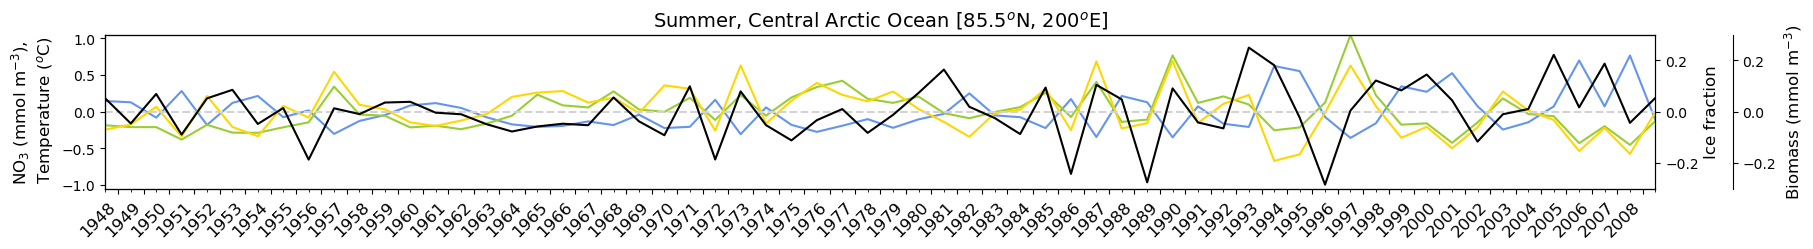

In [79]:
region = 'ao_b'
season = 'summer'
fig = plt.figure(figsize=(20, 2))
ax1 = fig.add_subplot(1,1,1);
ax2=ax1.twinx()
ax1.plot(np.nanmean(temp_ao_b_anom,axis=1),color=cm_new(0))
ax2.plot(np.nanmean(ECOSYS_IFRAC_ao_b_anom,axis=1),color=cm_new(1))
ax1.plot(np.nanmean(NO3_ao_b_anom,axis=1), color=cm_new(2))
ax1.set_title('Summer, Central Arctic Ocean [85.5$^o$N, 200$^o$E]', fontsize=lsize)
ax1.set_ylim(-1.05,1.05)
ax2.set_ylabel("Ice fraction",color='k',fontsize=12)
ax1.set_ylabel("NO$_3$ (mmol m$^{-3}$), \n Temperature ($^o$C)",color="k",fontsize=12)
plt.axhline(y=0, color='lightgray', linestyle='--')
ax2.set_ylim(-0.3,0.3)
ax3=ax1.twinx(); ax3.spines['right'].set_position(("axes", 1.05))
ax3.plot(np.nanmean(bmss_ao_b_anom,axis=1), color='k')
ax3.set_ylim(-0.3,0.3)
ax3.set_ylabel("Biomass (mmol m$^{-3})$",color="k",fontsize=12)
ax1.set_xticks(np.arange(0.5, 62, 1));
ax1.set_xticks(np.arange(0, 62, 1), minor=True);
ax1.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax1.margins(x=0)
region = 'ao_b'
season = 'summer'
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_anomaly.png', dpi=600, bbox_inches='tight')

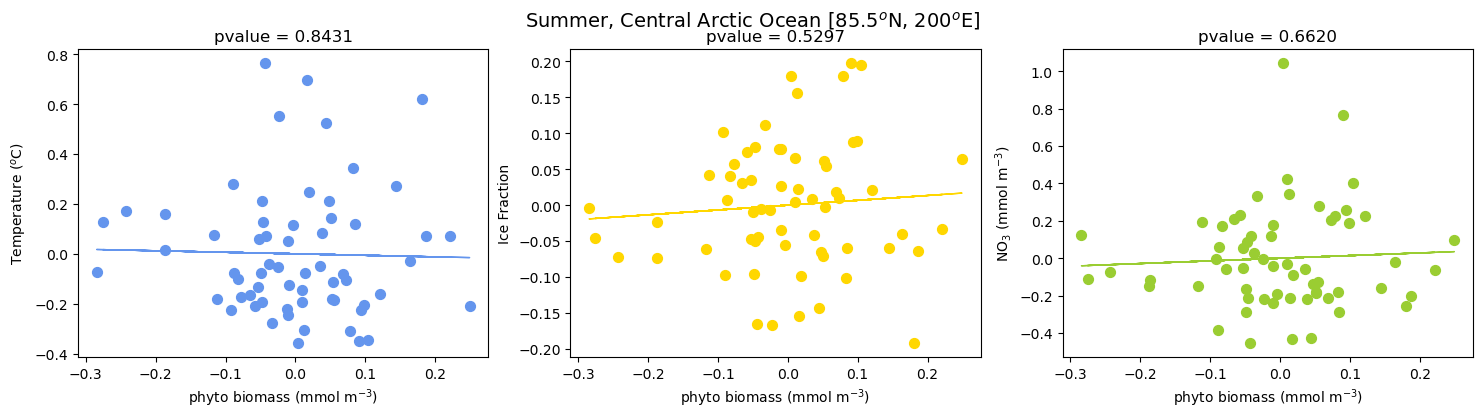

In [80]:
fig = plt.figure(figsize = (18,4))
# Separate the x and y axis
X1 = np.nanmean(bmss_ao_b_anom,axis=1)
Y1 = np.nanmean(temp_ao_b_anom,axis=1)
Y2 = np.nanmean(ECOSYS_IFRAC_ao_b_anom,axis=1)
Y3 = np.nanmean(NO3_ao_b_anom,axis=1)

# Calculate statistics (temperature & Biomass)
res1 = stats.linregress(X1, Y1)
YY1 = res1.intercept + res1.slope*X1

# Calculate statistics (Ice fraction & Biomass)
res2 = stats.linregress(X1, Y2)
YY2 = res2.intercept + res2.slope*X1

# Calculate statistics (NO3 & Biomass)
res3 = stats.linregress(X1, Y3)
YY3 = res3.intercept + res3.slope*X1

#Temperature & Biomass 
ax = fig.add_subplot(1,3,1)
ax.scatter(X1, Y1, color = cm_new(0), s = 50)
ax.plot(X1, YY1, color = cm_new(0), linewidth = 1, label='Temperature')
ax.set_title(f'pvalue = {res1.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Temperature ($^o$C)')
# Ice Fraction & Biomass 
ax = fig.add_subplot(1,3,2)
ax.scatter(X1, Y2, color = cm_new(1), s = 50)
ax.plot(X1, YY2, color = cm_new(1), linewidth = 1, label='Ice Fraction')
ax.set_title(f'pvalue = {res2.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Ice Fraction')
# NO3 & Biomass 
ax = fig.add_subplot(1,3,3)
ax.scatter(X1, Y3, color = cm_new(2), s = 50)
ax.plot(X1, YY3, color = cm_new(2), linewidth = 1, label='NO$_3$')
ax.set_title(f'pvalue = {res3.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
fig.suptitle('Summer, Central Arctic Ocean [85.5$^o$N, 200$^o$E]', fontsize=lsize)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_pvalue_T_Ice_NO3_biomass.png', dpi=600, bbox_inches='tight')

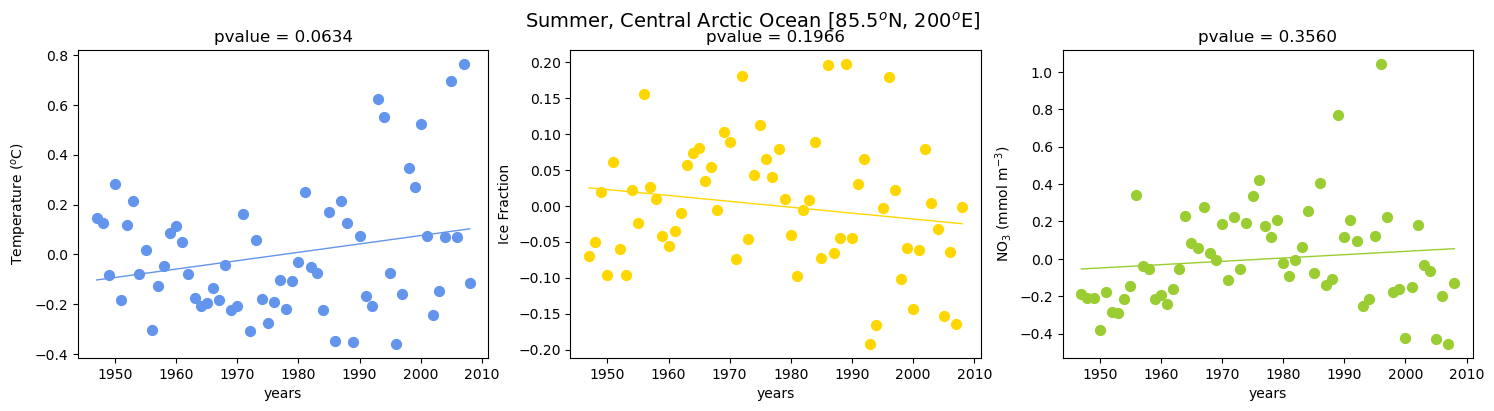

In [81]:
fig = plt.figure(figsize = (18,4))
# Separate the x and y axis
lsize=14
X1 = np.arange(1947,2009,1)
Y1 = np.nanmean(temp_ao_b_anom,axis=1)
Y2 = np.nanmean(ECOSYS_IFRAC_ao_b_anom,axis=1)
Y3 = np.nanmean(NO3_ao_b_anom,axis=1)

# Calculate statistics (temperature & time)
res1 = stats.linregress(X1, Y1)
YY1 = res1.intercept + res1.slope*X1

# Calculate statistics (Ice fraction & time)
res2 = stats.linregress(X1, Y2)
YY2 = res2.intercept + res2.slope*X1

# Calculate statistics (NO3 & time)
res3 = stats.linregress(X1, Y3)
YY3 = res3.intercept + res3.slope*X1

#Temperature & Biomass 
ax = fig.add_subplot(1,3,1)
ax.scatter(X1, Y1, color = cm_new(0), s = 50)
ax.plot(X1, YY1, color = cm_new(0), linewidth = 1, label='Temperature')
ax.set_title(f'pvalue = {res1.pvalue:.4f}')
ax.set_xlabel('years')
ax.set_ylabel('Temperature ($^o$C)')
# Ice Fraction & Biomass 
ax = fig.add_subplot(1,3,2)
ax.scatter(X1, Y2, color = cm_new(1), s = 50)
ax.plot(X1, YY2, color = cm_new(1), linewidth = 1, label='Ice Fraction')
ax.set_title(f'pvalue = {res2.pvalue:.4f}')
ax.set_xlabel('years')
ax.set_ylabel('Ice Fraction')
# NO3 & Biomass 
ax = fig.add_subplot(1,3,3)
ax.scatter(X1, Y3, color = cm_new(2), s = 50)
ax.plot(X1, YY3, color = cm_new(2), linewidth = 1, label='NO$_3$')
ax.set_title(f'pvalue = {res3.pvalue:.4f}')
ax.set_xlabel('years')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
fig.suptitle('Summer, Central Arctic Ocean [85.5$^o$N, 200$^o$E]', fontsize=lsize)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_pvalue_T_Ice_NO3_time.png', dpi=600, bbox_inches='tight')

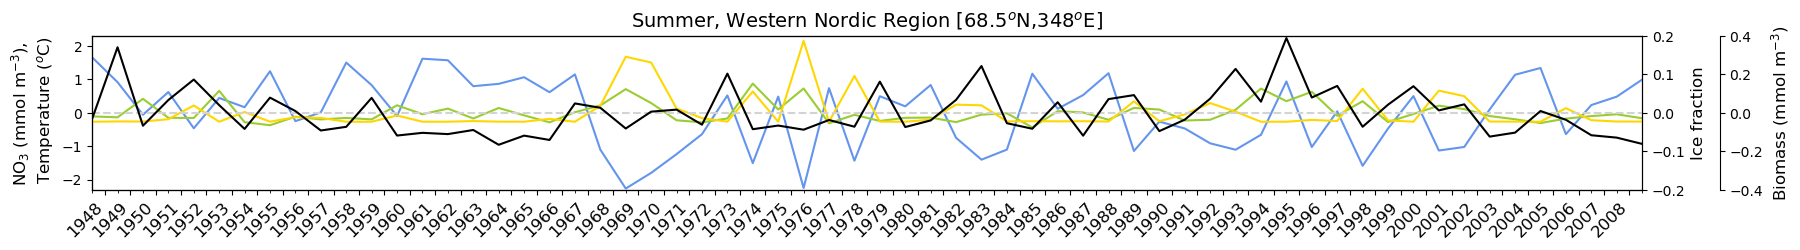

In [82]:
region = 'ao_k'
season = 'summer'
fig = plt.figure(figsize=(20, 2))
ax1 = fig.add_subplot(1,1,1);
ax2=ax1.twinx()
ax1.plot(np.nanmean(temp_ao_k_anom,axis=1),color=cm_new(0))
ax2.plot(np.nanmean(ECOSYS_IFRAC_ao_k_anom,axis=1),color=cm_new(1))
ax1.plot(np.nanmean(NO3_ao_k_anom,axis=1), color=cm_new(2))
ax1.set_title('Summer, Western Nordic Region [68.5$^o$N,348$^o$E]', fontsize=lsize)
ax1.set_ylim(-2.3,2.3)
ax2.set_ylabel("Ice fraction",color='k',fontsize=12)
ax1.set_ylabel("NO$_3$ (mmol m$^{-3}$), \n Temperature ($^o$C)",color="k",fontsize=12)
plt.axhline(y=0, color='lightgray', linestyle='--')
ax2.set_ylim(-0.2,0.2)
ax3=ax1.twinx(); ax3.spines['right'].set_position(("axes", 1.05))
ax3.plot(np.nanmean(bmss_ao_k_anom,axis=1), color='k')
ax3.set_ylim(-0.4,0.4)
ax3.set_ylabel("Biomass (mmol m$^{-3})$",color="k",fontsize=12)
ax1.set_xticks(np.arange(0.5, 62, 1));
ax1.set_xticks(np.arange(0, 62, 1), minor=True);
ax1.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax1.margins(x=0)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_anomaly.png', dpi=600, bbox_inches='tight')

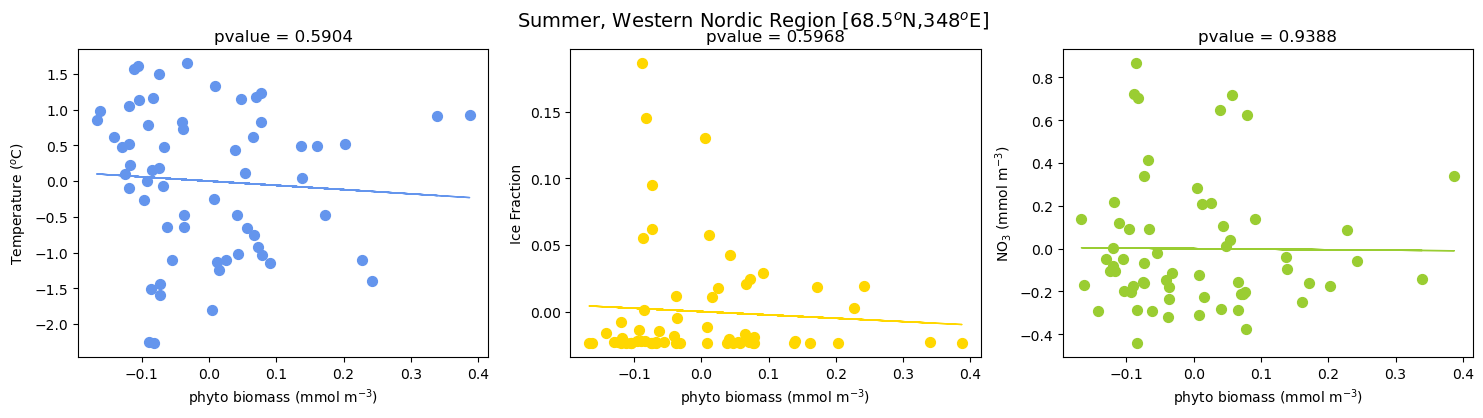

In [83]:
fig = plt.figure(figsize = (18,4))
# Separate the x and y axis
X1 = np.nanmean(bmss_ao_k_anom,axis=1)
Y1 = np.nanmean(temp_ao_k_anom,axis=1)
Y2 = np.nanmean(ECOSYS_IFRAC_ao_k_anom,axis=1)
Y3 = np.nanmean(NO3_ao_k_anom,axis=1)

# Calculate statistics (temperature & Biomass)
res1 = stats.linregress(X1, Y1)
YY1 = res1.intercept + res1.slope*X1

# Calculate statistics (Ice fraction & Biomass)
res2 = stats.linregress(X1, Y2)
YY2 = res2.intercept + res2.slope*X1

# Calculate statistics (NO3 & Biomass)
res3 = stats.linregress(X1, Y3)
YY3 = res3.intercept + res3.slope*X1

#Temperature & Biomass 
ax = fig.add_subplot(1,3,1)
ax.scatter(X1, Y1, color = cm_new(0), s = 50)
ax.plot(X1, YY1, color = cm_new(0), linewidth = 1, label='Temperature')
ax.set_title(f'pvalue = {res1.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Temperature ($^o$C)')
# Ice Fraction & Biomass 
ax = fig.add_subplot(1,3,2)
ax.scatter(X1, Y2, color = cm_new(1), s = 50)
ax.plot(X1, YY2, color = cm_new(1), linewidth = 1, label='Ice Fraction')
ax.set_title(f'pvalue = {res2.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Ice Fraction')
# NO3 & Biomass 
ax = fig.add_subplot(1,3,3)
ax.scatter(X1, Y3, color = cm_new(2), s = 50)
ax.plot(X1, YY3, color = cm_new(2), linewidth = 1, label='NO$_3$')
ax.set_title(f'pvalue = {res3.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
fig.suptitle('Summer, Western Nordic Region [68.5$^o$N,348$^o$E]', fontsize=lsize)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_pvalue_T_Ice_NO3_biomass.png', dpi=600, bbox_inches='tight')

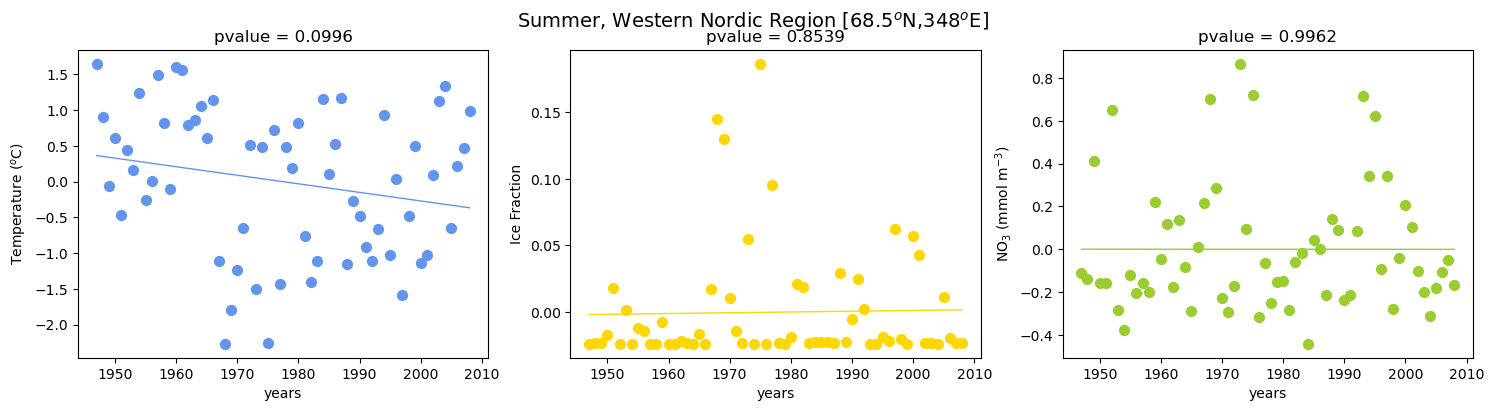

In [84]:
fig = plt.figure(figsize = (18,4))
# Separate the x and y axis
lsize=14
X1 = np.arange(1947,2009,1)
Y1 = np.nanmean(temp_ao_k_anom,axis=1)
Y2 = np.nanmean(ECOSYS_IFRAC_ao_k_anom,axis=1)
Y3 = np.nanmean(NO3_ao_k_anom,axis=1)

# Calculate statistics (temperature & time)
res1 = stats.linregress(X1, Y1)
YY1 = res1.intercept + res1.slope*X1

# Calculate statistics (Ice fraction & time)
res2 = stats.linregress(X1, Y2)
YY2 = res2.intercept + res2.slope*X1

# Calculate statistics (NO3 & time)
res3 = stats.linregress(X1, Y3)
YY3 = res3.intercept + res3.slope*X1

#Temperature & Biomass 
ax = fig.add_subplot(1,3,1)
ax.scatter(X1, Y1, color = cm_new(0), s = 50)
ax.plot(X1, YY1, color = cm_new(0), linewidth = 1, label='Temperature')
ax.set_title(f'pvalue = {res1.pvalue:.4f}')
ax.set_xlabel('years')
ax.set_ylabel('Temperature ($^o$C)')
# Ice Fraction & Biomass 
ax = fig.add_subplot(1,3,2)
ax.scatter(X1, Y2, color = cm_new(1), s = 50)
ax.plot(X1, YY2, color = cm_new(1), linewidth = 1, label='Ice Fraction')
ax.set_title(f'pvalue = {res2.pvalue:.4f}')
ax.set_xlabel('years')
ax.set_ylabel('Ice Fraction')
# NO3 & Biomass 
ax = fig.add_subplot(1,3,3)
ax.scatter(X1, Y3, color = cm_new(2), s = 50)
ax.plot(X1, YY3, color = cm_new(2), linewidth = 1, label='NO$_3$')
ax.set_title(f'pvalue = {res3.pvalue:.4f}')
ax.set_xlabel('years')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
fig.suptitle('Summer, Western Nordic Region [68.5$^o$N,348$^o$E]', fontsize=lsize)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_pvalue_T_Ice_NO3_time.png', dpi=600, bbox_inches='tight')

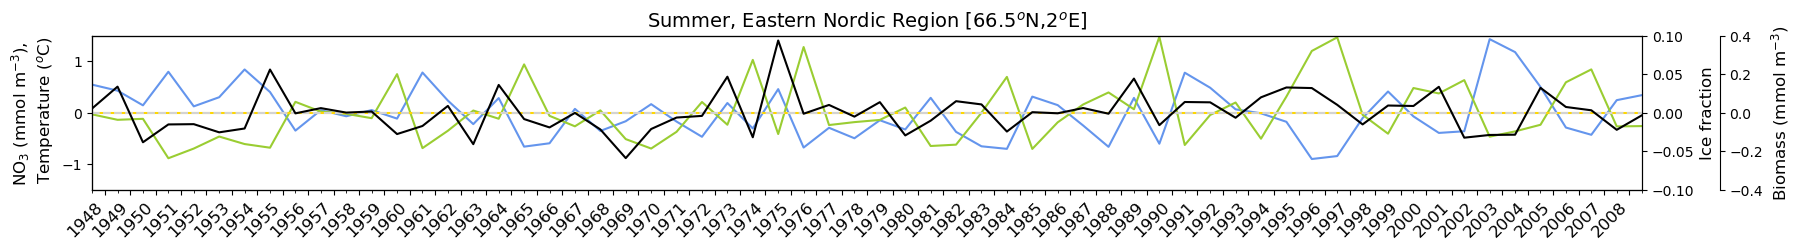

In [85]:
region = 'ao_r'
season = 'summer'
fig = plt.figure(figsize=(20, 2))
ax1 = fig.add_subplot(1,1,1);
ax2=ax1.twinx()
ax1.plot(np.nanmean(temp_ao_r_anom,axis=1),color=cm_new(0))
ax2.plot(np.nanmean(ECOSYS_IFRAC_ao_r_anom,axis=1),color=cm_new(1))
ax1.plot(np.nanmean(NO3_ao_r_anom,axis=1), color=cm_new(2))
ax1.set_title('Summer, Eastern Nordic Region [66.5$^o$N,2$^o$E]', fontsize=lsize)
ax1.set_ylim(-1.5,1.5)
ax2.set_ylabel("Ice fraction",color='k',fontsize=12)
ax1.set_ylabel("NO$_3$ (mmol m$^{-3}$), \n Temperature ($^o$C)",color="k",fontsize=12)
plt.axhline(y=0, color='lightgray', linestyle='--')
ax2.set_ylim(-0.1,0.1)
ax3=ax1.twinx(); ax3.spines['right'].set_position(("axes", 1.05))
ax3.plot(np.nanmean(bmss_ao_r_anom,axis=1), color='k')
ax3.set_ylim(-0.4,0.4)
ax3.set_ylabel("Biomass (mmol m$^{-3})$",color="k",fontsize=12)
ax1.set_xticks(np.arange(0.5, 62, 1));
ax1.set_xticks(np.arange(0, 62, 1), minor=True);
ax1.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax1.margins(x=0)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_anomaly.png', dpi=600, bbox_inches='tight')

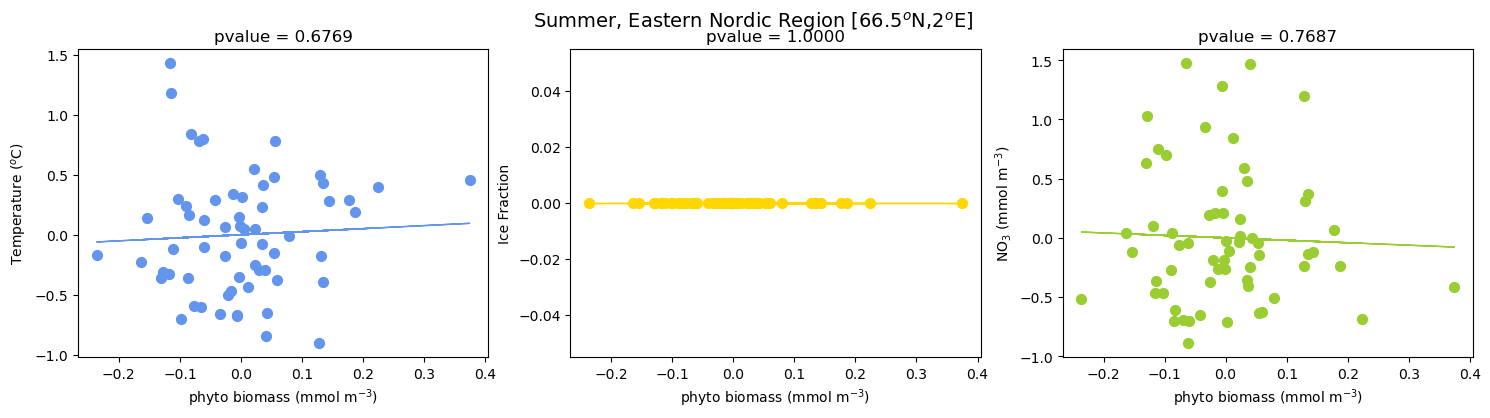

In [86]:
fig = plt.figure(figsize = (18,4))
# Separate the x and y axis
X1 = np.nanmean(bmss_ao_r_anom,axis=1)
Y1 = np.nanmean(temp_ao_r_anom,axis=1)
Y2 = np.nanmean(ECOSYS_IFRAC_ao_r_anom,axis=1)
Y3 = np.nanmean(NO3_ao_r_anom,axis=1)

# Calculate statistics (temperature & Biomass)
res1 = stats.linregress(X1, Y1)
YY1 = res1.intercept + res1.slope*X1

# Calculate statistics (Ice fraction & Biomass)
res2 = stats.linregress(X1, Y2)
YY2 = res2.intercept + res2.slope*X1

# Calculate statistics (NO3 & Biomass)
res3 = stats.linregress(X1, Y3)
YY3 = res3.intercept + res3.slope*X1

#Temperature & Biomass 
ax = fig.add_subplot(1,3,1)
ax.scatter(X1, Y1, color = cm_new(0), s = 50)
ax.plot(X1, YY1, color = cm_new(0), linewidth = 1, label='Temperature')
ax.set_title(f'pvalue = {res1.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Temperature ($^o$C)')
# Ice Fraction & Biomass 
ax = fig.add_subplot(1,3,2)
ax.scatter(X1, Y2, color = cm_new(1), s = 50)
ax.plot(X1, YY2, color = cm_new(1), linewidth = 1, label='Ice Fraction')
ax.set_title(f'pvalue = {res2.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Ice Fraction')
# NO3 & Biomass 
ax = fig.add_subplot(1,3,3)
ax.scatter(X1, Y3, color = cm_new(2), s = 50)
ax.plot(X1, YY3, color = cm_new(2), linewidth = 1, label='NO$_3$')
ax.set_title(f'pvalue = {res3.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
fig.suptitle('Summer, Eastern Nordic Region [66.5$^o$N,2$^o$E]', fontsize=lsize)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_pvalue_T_Ice_NO3_biomass.png', dpi=600, bbox_inches='tight')

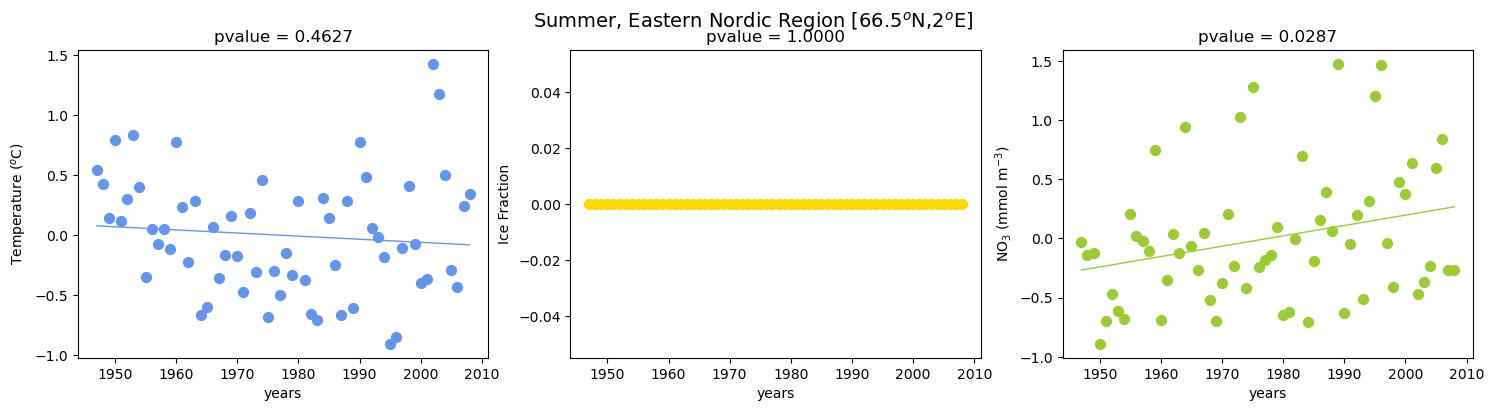

In [87]:
fig = plt.figure(figsize = (18,4))
# Separate the x and y axis
lsize=14
X1 = np.arange(1947,2009,1)
Y1 = np.nanmean(temp_ao_r_anom,axis=1)
Y2 = np.nanmean(ECOSYS_IFRAC_ao_r_anom,axis=1)
Y3 = np.nanmean(NO3_ao_r_anom,axis=1)

# Calculate statistics (temperature & time)
res1 = stats.linregress(X1, Y1)
YY1 = res1.intercept + res1.slope*X1

# Calculate statistics (Ice fraction & time)
res2 = stats.linregress(X1, Y2)
YY2 = res2.intercept + res2.slope*X1

# Calculate statistics (NO3 & time)
res3 = stats.linregress(X1, Y3)
YY3 = res3.intercept + res3.slope*X1

#Temperature & Biomass 
ax = fig.add_subplot(1,3,1)
ax.scatter(X1, Y1, color = cm_new(0), s = 50)
ax.plot(X1, YY1, color = cm_new(0), linewidth = 1, label='Temperature')
ax.set_title(f'pvalue = {res1.pvalue:.4f}')
ax.set_xlabel('years')
ax.set_ylabel('Temperature ($^o$C)')
# Ice Fraction & Biomass 
ax = fig.add_subplot(1,3,2)
ax.scatter(X1, Y2, color = cm_new(1), s = 50)
ax.plot(X1, YY2, color = cm_new(1), linewidth = 1, label='Ice Fraction')
ax.set_title(f'pvalue = {res2.pvalue:.4f}')
ax.set_xlabel('years')
ax.set_ylabel('Ice Fraction')
# NO3 & Biomass 
ax = fig.add_subplot(1,3,3)
ax.scatter(X1, Y3, color = cm_new(2), s = 50)
ax.plot(X1, YY3, color = cm_new(2), linewidth = 1, label='NO$_3$')
ax.set_title(f'pvalue = {res3.pvalue:.4f}')
ax.set_xlabel('years')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
fig.suptitle('Summer, Eastern Nordic Region [66.5$^o$N,2$^o$E]', fontsize=lsize)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_pvalue_T_Ice_NO3_time.png', dpi=600, bbox_inches='tight')

## Whole Arctic

In [88]:
%%time
temp_ao = np.nanmean(temp_ds_inter[0:62,:,149:180,:], axis=(2,3))
temp_ao_anom = temp_ao[:,5:8]-np.nanmean(temp_ao[:,5:8],axis=0)

ECOSYS_IFRAC_ao = np.nanmean(ECOSYS_IFRAC_ds_inter[0:62,:,149:180,:], axis=(2,3))
ECOSYS_IFRAC_ao_anom = ECOSYS_IFRAC_ao[:,5:8]-np.nanmean(ECOSYS_IFRAC_ao[:,5:8],axis=0)

NO3_ao = np.nanmean(NO3_ds_inter[0:62,:,149:180,:], axis=(2,3))
NO3_ao_anom = NO3_ao[:,5:8]-np.nanmean(NO3_ao[:,5:8],axis=0)

bmss_ao = np.nanmean(bmss_tot[:,:,149:180,:], axis=(2,3))
bmss_ao_anom = bmss_ao[:,5:8]-np.nanmean(bmss_ao[:,5:8],axis=0)

CPU times: user 98.6 ms, sys: 51.3 ms, total: 150 ms
Wall time: 150 ms


In [89]:
NO3_ds_inter[0:62,:,149:180,:].shape

(62, 12, 31, 360)

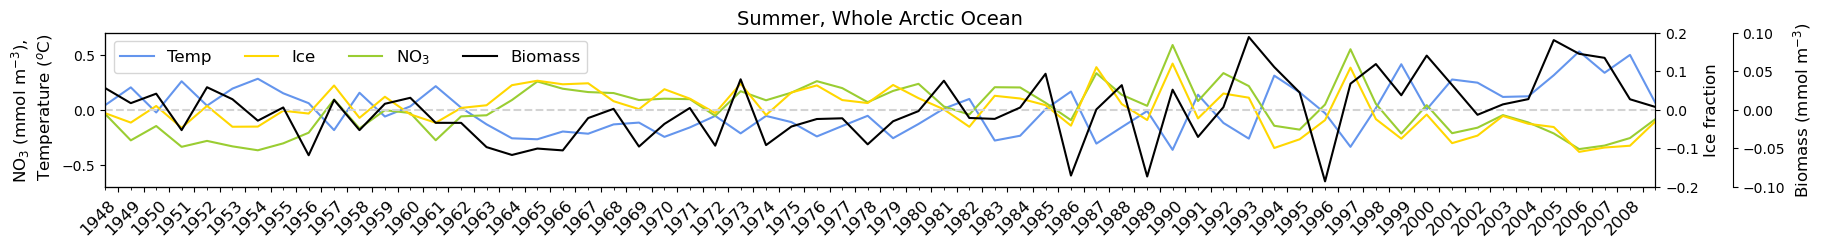

In [90]:
region = 'wao'
season = 'summer'

fig = plt.figure(figsize=(20, 2))

# Subplot 1
ax1 = fig.add_subplot(1,1,1);
ax2=ax1.twinx()
ln1=ax1.plot(np.nanmean(temp_ao_anom,axis=1),color=cm_new(0),label = 'Temp')
ln2=ax2.plot(np.nanmean(ECOSYS_IFRAC_ao_anom,axis=1),color=cm_new(1),label = 'Ice')
ln3=ax1.plot(np.nanmean(NO3_ao_anom,axis=1), color=cm_new(2),label = 'NO$_3$')
ax1.set_title('Summer, Whole Arctic Ocean', fontsize=14)
ax1.set_ylim(-0.7,0.7)
ax2.set_ylabel("Ice fraction",color='k',fontsize=12)
ax1.set_ylabel("NO$_3$ (mmol m$^{-3}$), \n Temperature ($^o$C)",color="k",fontsize=12)
plt.axhline(y=0, color='lightgray', linestyle='--')
ax2.set_ylim(-0.2,0.2)
ax3=ax1.twinx(); ax3.spines['right'].set_position(("axes", 1.05))
ln4 = ax3.plot(np.nanmean(bmss_ao_anom,axis=1), color='k',label = 'Biomass')
ax3.set_ylim(-0.1,0.1)
ax3.set_ylabel("Biomass (mmol m$^{-3})$",color="k",fontsize=12)
ax1.set_xticks(np.arange(0.5, 62, 1));
ax1.set_xticks(np.arange(0, 62, 1), minor=True);
ax1.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax1.margins(x=0)
lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2,ncol=4,fontsize=12)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}_{region}_{season}_anomaly.png', dpi=600, bbox_inches='tight')

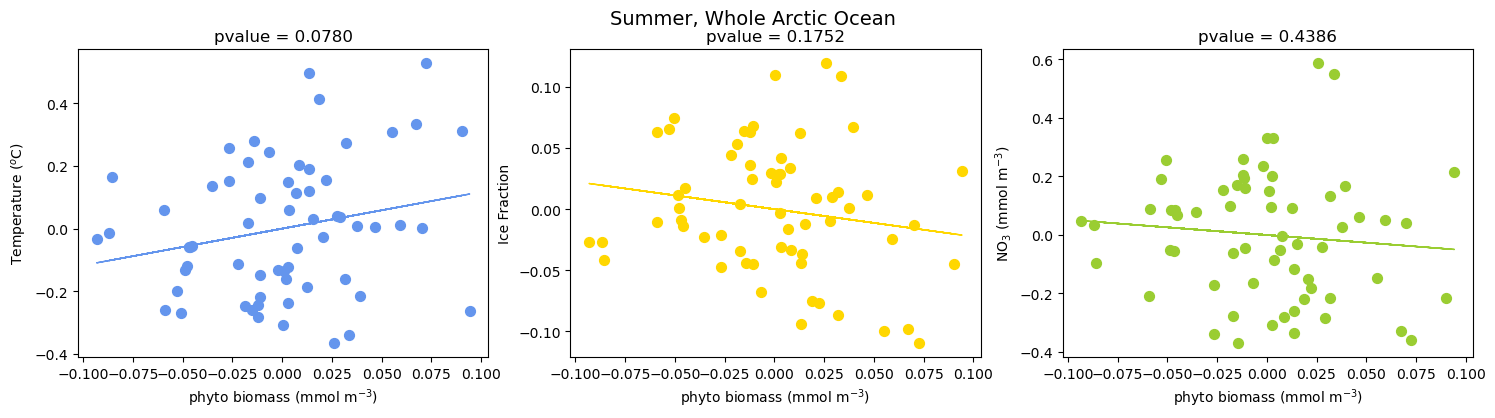

In [91]:
fig = plt.figure(figsize = (18,4))
# Separate the x and y axis
X1 = np.nanmean(bmss_ao_anom,axis=1)
Y1 = np.nanmean(temp_ao_anom,axis=1)
Y2 = np.nanmean(ECOSYS_IFRAC_ao_anom,axis=1)
Y3 = np.nanmean(NO3_ao_anom,axis=1)

# Calculate statistics (temperature & Biomass)
res1 = stats.linregress(X1, Y1)
YY1 = res1.intercept + res1.slope*X1

# Calculate statistics (Ice fraction & Biomass)
res2 = stats.linregress(X1, Y2)
YY2 = res2.intercept + res2.slope*X1

# Calculate statistics (NO3 & Biomass)
res3 = stats.linregress(X1, Y3)
YY3 = res3.intercept + res3.slope*X1

#Temperature & Biomass 
ax = fig.add_subplot(1,3,1)
ax.scatter(X1, Y1, color = cm_new(0), s = 50)
ax.plot(X1, YY1, color = cm_new(0), linewidth = 1, label='Temperature')
ax.set_title(f'pvalue = {res1.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Temperature ($^o$C)')
# Ice Fraction & Biomass 
ax = fig.add_subplot(1,3,2)
ax.scatter(X1, Y2, color = cm_new(1), s = 50)
ax.plot(X1, YY2, color = cm_new(1), linewidth = 1, label='Ice Fraction')
ax.set_title(f'pvalue = {res2.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Ice Fraction')
# NO3 & Biomass 
ax = fig.add_subplot(1,3,3)
ax.scatter(X1, Y3, color = cm_new(2), s = 50)
ax.plot(X1, YY3, color = cm_new(2), linewidth = 1, label='NO$_3$')
ax.set_title(f'pvalue = {res3.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
fig.suptitle('Summer, Whole Arctic Ocean', fontsize=lsize)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_pvalue_T_Ice_NO3_biomass.png', dpi=600, bbox_inches='tight')

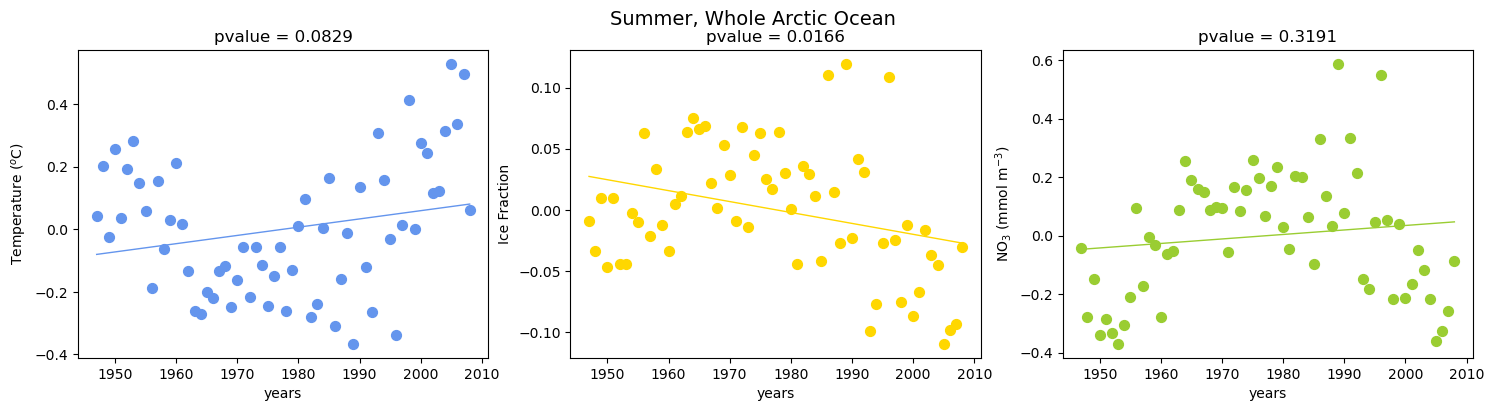

In [92]:
fig = plt.figure(figsize = (18,4))
# Separate the x and y axis
lsize=14
X1 = np.arange(1947,2009,1)
Y1 = np.nanmean(temp_ao_anom,axis=1)
Y2 = np.nanmean(ECOSYS_IFRAC_ao_anom,axis=1)
Y3 = np.nanmean(NO3_ao_anom,axis=1)

# Calculate statistics (temperature & time)
res1 = stats.linregress(X1, Y1)
YY1 = res1.intercept + res1.slope*X1

# Calculate statistics (Ice fraction & time)
res2 = stats.linregress(X1, Y2)
YY2 = res2.intercept + res2.slope*X1

# Calculate statistics (NO3 & time)
res3 = stats.linregress(X1, Y3)
YY3 = res3.intercept + res3.slope*X1

#Temperature & Biomass 
ax = fig.add_subplot(1,3,1)
ax.scatter(X1, Y1, color = cm_new(0), s = 50)
ax.plot(X1, YY1, color = cm_new(0), linewidth = 1, label='Temperature')
ax.set_title(f'pvalue = {res1.pvalue:.4f}')
ax.set_xlabel('years')
ax.set_ylabel('Temperature ($^o$C)')
# Ice Fraction & Biomass 
ax = fig.add_subplot(1,3,2)
ax.scatter(X1, Y2, color = cm_new(1), s = 50)
ax.plot(X1, YY2, color = cm_new(1), linewidth = 1, label='Ice Fraction')
ax.set_title(f'pvalue = {res2.pvalue:.4f}')
ax.set_xlabel('years')
ax.set_ylabel('Ice Fraction')
# NO3 & Biomass 
ax = fig.add_subplot(1,3,3)
ax.scatter(X1, Y3, color = cm_new(2), s = 50)
ax.plot(X1, YY3, color = cm_new(2), linewidth = 1, label='NO$_3$')
ax.set_title(f'pvalue = {res3.pvalue:.4f}')
ax.set_xlabel('years')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
fig.suptitle('Summer, Whole Arctic Ocean', fontsize=lsize)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_pvalue_T_Ice_NO3_time.png', dpi=600, bbox_inches='tight')

## Annomaly plots in the spring

In [69]:
temp_ao_b_anom = temp_ds_inter[:,2:5,175,20]-np.nanmean(temp_ds_inter[:,2:5,175,20],axis=0)
temp_ao_k_anom = temp_ds_inter[:,2:5,158,168]-np.nanmean(temp_ds_inter[:,2:5,158,168],axis=0)
temp_ao_r_anom = temp_ds_inter[:,2:5,156,182]-np.nanmean(temp_ds_inter[:,2:5,156,182],axis=0)

NO3_ao_b_anom = NO3_ds_inter[:,2:5,175,20]-np.nanmean(NO3_ds_inter[:,2:5,175,20],axis=0)
NO3_ao_k_anom = NO3_ds_inter[:,2:5,158,168]-np.nanmean(NO3_ds_inter[:,2:5,158,168],axis=0)
NO3_ao_r_anom = NO3_ds_inter[:,2:5,156,182]-np.nanmean(NO3_ds_inter[:,2:5,156,182],axis=0)

bmss_ao_b_anom = bmss_tot[:,2:5,175,20]-np.nanmean(bmss_tot[:,2:5,175,20],axis=0)
bmss_ao_k_anom = bmss_tot[:,2:5,158,168]-np.nanmean(bmss_tot[:,2:5,158,168],axis=0)
bmss_ao_r_anom = bmss_tot[:,2:5,156,182]-np.nanmean(bmss_tot[:,2:5,156,182],axis=0)

ECOSYS_IFRAC_ao_b_anom = ECOSYS_IFRAC_ds_inter[:,2:5,175,20]-np.nanmean(ECOSYS_IFRAC_ds_inter[:,2:5,175,20],axis=0)
ECOSYS_IFRAC_ao_k_anom = ECOSYS_IFRAC_ds_inter[:,2:5,158,168]-np.nanmean(ECOSYS_IFRAC_ds_inter[:,2:5,158,168],axis=0)
ECOSYS_IFRAC_ao_r_anom = ECOSYS_IFRAC_ds_inter[:,2:5,156,182]-np.nanmean(ECOSYS_IFRAC_ds_inter[:,2:5,156,182],axis=0)

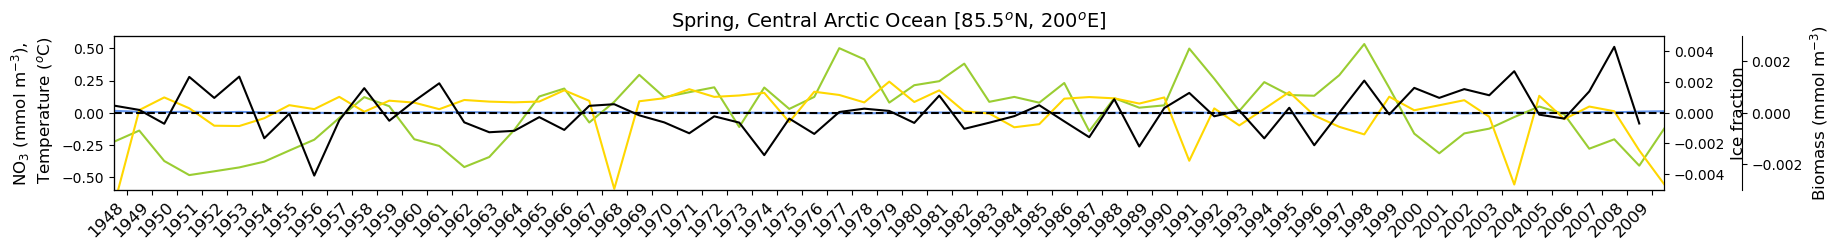

In [89]:
fig = plt.figure(figsize=(20, 2))
ax1 = fig.add_subplot(1,1,1);
ax2=ax1.twinx()
ax1.plot(np.nanmean(temp_ao_b_anom,axis=1),color=cm_new(0))
ax2.plot(np.nanmean(ECOSYS_IFRAC_ao_b_anom,axis=1),color=cm_new(1))
ax1.plot(np.nanmean(NO3_ao_b_anom,axis=1), color=cm_new(2))
ax1.set_title('Spring, Central Arctic Ocean [85.5$^o$N, 200$^o$E]', fontsize=lsize)
ax1.set_xticks(np.arange(0.5, 62, 1));
ax1.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax1.set_ylim(-0.6,0.6)
ax2.set_ylabel("Ice fraction",color='k',fontsize=12)
ax1.set_ylabel("NO$_3$ (mmol m$^{-3}$), \n Temperature ($^o$C)",color="k",fontsize=12)
plt.axhline(y=0, color='k', linestyle='--')
ax2.set_ylim(-0.005,0.005)
ax3=ax1.twinx(); ax3.spines['right'].set_position(("axes", 1.05))
ax3.plot(np.nanmean(bmss_ao_b_anom,axis=1), color='k')
ax3.set_ylim(-0.003,0.003)
ax3.set_ylabel("Biomass (mmol m$^{-3})$",color="k",fontsize=12)
ax1.margins(x=0)
region = 'ao_b'
season = 'spring'
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_anomaly.png', dpi=600, bbox_inches='tight')

Text(0.5, 0.98, 'Spring, Central Arctic Ocean [85.5$^o$N, 200$^o$E]')

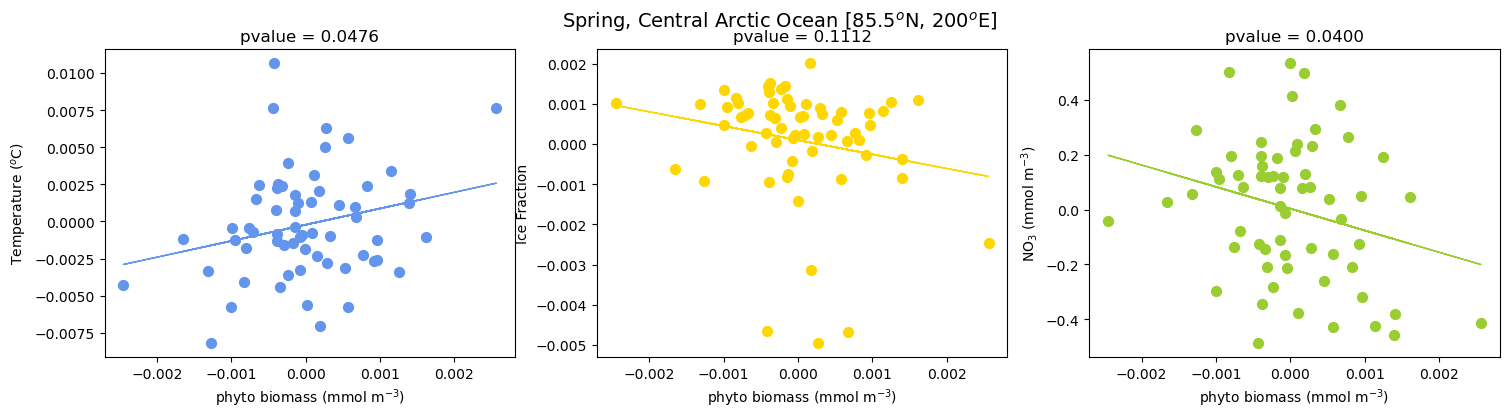

In [96]:
fig = plt.figure(figsize = (18,4))
# Separate the x and y axis
X1 = np.nanmean(bmss_ao_b_anom,axis=1)
Y1 = np.nanmean(temp_ao_b_anom[1::],axis=1)
Y2 = np.nanmean(ECOSYS_IFRAC_ao_b_anom[1::],axis=1)
Y3 = np.nanmean(NO3_ao_b_anom[1::],axis=1)

# Calculate statistics (temperature & Biomass)
res1 = stats.linregress(X1, Y1)
YY1 = res1.intercept + res1.slope*X1

# Calculate statistics (Ice fraction & Biomass)
res2 = stats.linregress(X1, Y2)
YY2 = res2.intercept + res2.slope*X1

# Calculate statistics (NO3 & Biomass)
res3 = stats.linregress(X1, Y3)
YY3 = res3.intercept + res3.slope*X1

#Temperature & Biomass 
ax = fig.add_subplot(1,3,1)
ax.scatter(X1, Y1, color = cm_new(0), s = 50)
ax.plot(X1, YY1, color = cm_new(0), linewidth = 1, label='Temperature')
ax.set_title(f'pvalue = {res1.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Temperature ($^o$C)')
# Ice Fraction & Biomass 
ax = fig.add_subplot(1,3,2)
ax.scatter(X1, Y2, color = cm_new(1), s = 50)
ax.plot(X1, YY2, color = cm_new(1), linewidth = 1, label='Ice Fraction')
ax.set_title(f'pvalue = {res2.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Ice Fraction')
# NO3 & Biomass 
ax = fig.add_subplot(1,3,3)
ax.scatter(X1, Y3, color = cm_new(2), s = 50)
ax.plot(X1, YY3, color = cm_new(2), linewidth = 1, label='NO$_3$')
ax.set_title(f'pvalue = {res3.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
fig.suptitle('Spring, Central Arctic Ocean [85.5$^o$N, 200$^o$E]', fontsize=lsize)

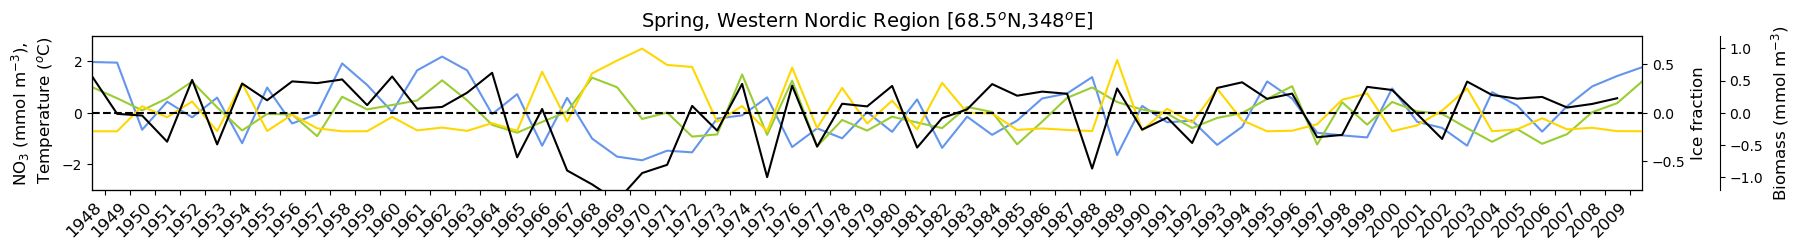

In [97]:
region = 'ao_k'
season = 'spring'
fig = plt.figure(figsize=(20, 2))
ax1 = fig.add_subplot(1,1,1);
ax2=ax1.twinx()
ax1.plot(np.nanmean(temp_ao_k_anom,axis=1),color=cm_new(0))
ax2.plot(np.nanmean(ECOSYS_IFRAC_ao_k_anom,axis=1),color=cm_new(1))
ax1.plot(np.nanmean(NO3_ao_k_anom,axis=1), color=cm_new(2))
ax1.set_title('Spring, Western Nordic Region [68.5$^o$N,348$^o$E]', fontsize=lsize)
ax1.set_xticks(np.arange(0.5, 62, 1));
ax1.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax1.set_ylim(-3,3)
ax2.set_ylabel("Ice fraction",color='k',fontsize=12)
ax1.set_ylabel("NO$_3$ (mmol m$^{-3}$), \n Temperature ($^o$C)",color="k",fontsize=12)
plt.axhline(y=0, color='k', linestyle='--')
ax2.set_ylim(-0.8,0.8)
ax3=ax1.twinx(); ax3.spines['right'].set_position(("axes", 1.05))
ax3.plot(np.nanmean(bmss_ao_k_anom,axis=1), color='k')
ax3.set_ylim(-1.2,1.2)
ax3.set_ylabel("Biomass (mmol m$^{-3})$",color="k",fontsize=12)
ax1.margins(x=0)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_anomaly.png', dpi=600, bbox_inches='tight')

Text(0.5, 0.98, 'Spring, Western Nordic Region [68.5$^o$N,348$^o$E]')

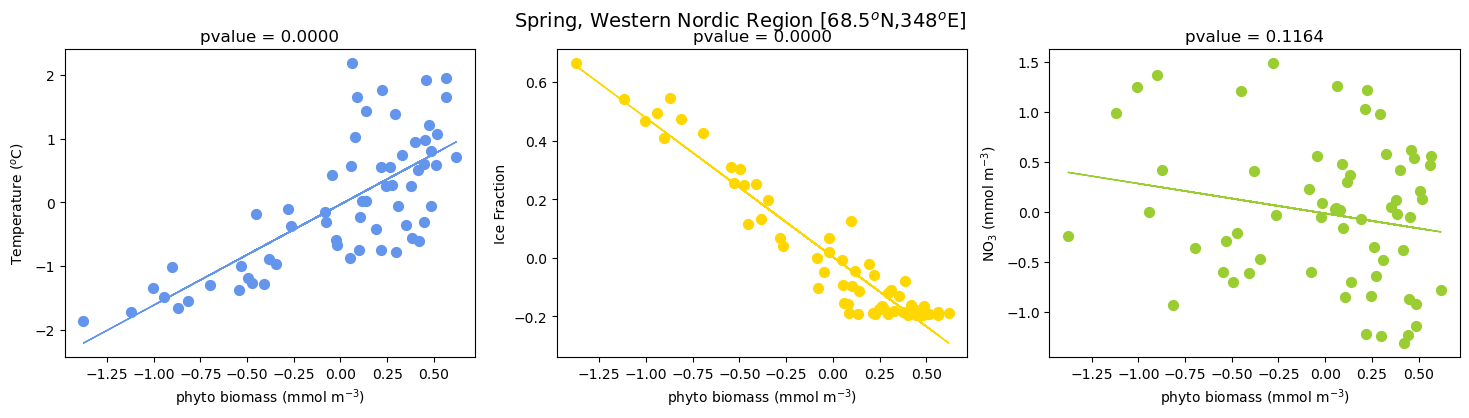

In [98]:
fig = plt.figure(figsize = (18,4))
# Separate the x and y axis
X1 = np.nanmean(bmss_ao_k_anom,axis=1)
Y1 = np.nanmean(temp_ao_k_anom[1::],axis=1)
Y2 = np.nanmean(ECOSYS_IFRAC_ao_k_anom[1::],axis=1)
Y3 = np.nanmean(NO3_ao_k_anom[1::],axis=1)

# Calculate statistics (temperature & Biomass)
res1 = stats.linregress(X1, Y1)
YY1 = res1.intercept + res1.slope*X1

# Calculate statistics (Ice fraction & Biomass)
res2 = stats.linregress(X1, Y2)
YY2 = res2.intercept + res2.slope*X1

# Calculate statistics (NO3 & Biomass)
res3 = stats.linregress(X1, Y3)
YY3 = res3.intercept + res3.slope*X1

#Temperature & Biomass 
ax = fig.add_subplot(1,3,1)
ax.scatter(X1, Y1, color = cm_new(0), s = 50)
ax.plot(X1, YY1, color = cm_new(0), linewidth = 1, label='Temperature')
ax.set_title(f'pvalue = {res1.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Temperature ($^o$C)')
# Ice Fraction & Biomass 
ax = fig.add_subplot(1,3,2)
ax.scatter(X1, Y2, color = cm_new(1), s = 50)
ax.plot(X1, YY2, color = cm_new(1), linewidth = 1, label='Ice Fraction')
ax.set_title(f'pvalue = {res2.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Ice Fraction')
# NO3 & Biomass 
ax = fig.add_subplot(1,3,3)
ax.scatter(X1, Y3, color = cm_new(2), s = 50)
ax.plot(X1, YY3, color = cm_new(2), linewidth = 1, label='NO$_3$')
ax.set_title(f'pvalue = {res3.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
fig.suptitle('Spring, Western Nordic Region [68.5$^o$N,348$^o$E]', fontsize=lsize)

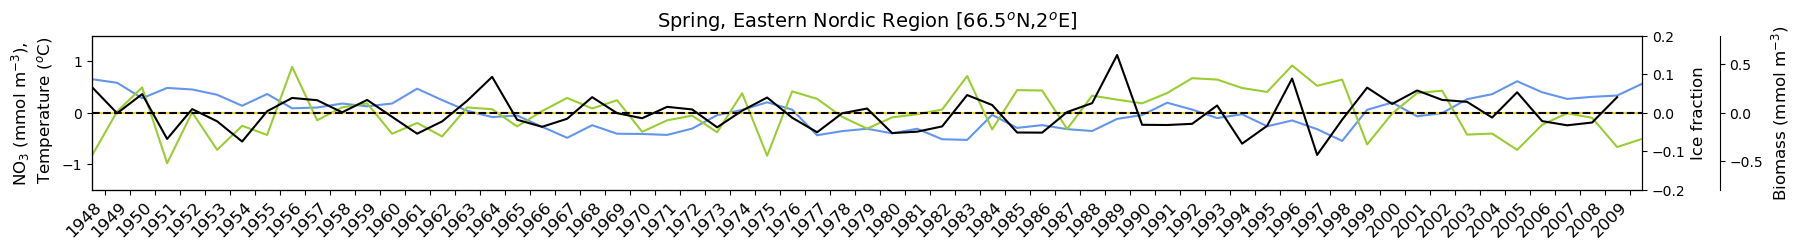

In [99]:
region = 'ao_r'
season = 'spring'
lsize=14
fig = plt.figure(figsize=(20, 2))
ax1 = fig.add_subplot(1,1,1);
ax2=ax1.twinx()
ax1.plot(np.nanmean(temp_ao_r_anom,axis=1),color=cm_new(0))
ax2.plot(np.nanmean(ECOSYS_IFRAC_ao_r_anom,axis=1),color=cm_new(1))
ax1.plot(np.nanmean(NO3_ao_r_anom,axis=1), color=cm_new(2))
ax1.set_title('Spring, Eastern Nordic Region [66.5$^o$N,2$^o$E]', fontsize=lsize)
ax1.set_xticks(np.arange(0.5, 62, 1));
ax1.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax1.set_ylim(-1.5,1.5)
ax2.set_ylabel("Ice fraction",color='k',fontsize=12)
ax1.set_ylabel("NO$_3$ (mmol m$^{-3}$), \n Temperature ($^o$C)",color="k",fontsize=12)
plt.axhline(y=0, color='k', linestyle='--')
ax2.set_ylim(-0.2,0.2)
ax3=ax1.twinx(); ax3.spines['right'].set_position(("axes", 1.05))
ax3.plot(np.nanmean(bmss_ao_r_anom,axis=1), color='k')
ax3.set_ylim(-0.8,0.8)
ax3.set_ylabel("Biomass (mmol m$^{-3})$",color="k",fontsize=12)
ax1.margins(x=0)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_anomaly.png', dpi=600, bbox_inches='tight')

Text(0.5, 0.98, 'Spring, Eastern Nordic Region [66.5$^o$N,2$^o$E]')

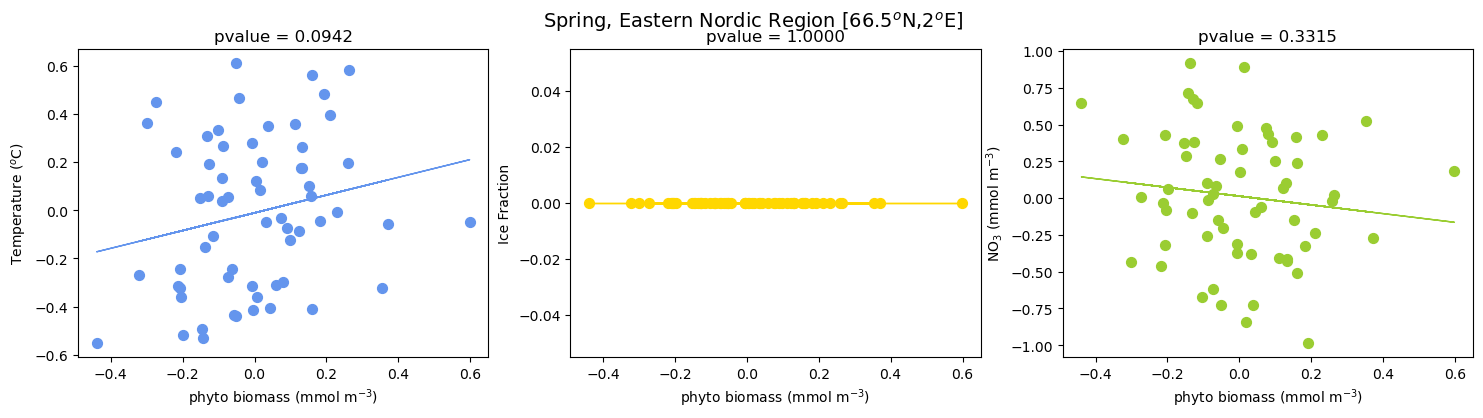

In [100]:
fig = plt.figure(figsize = (18,4))
# Separate the x and y axis
X1 = np.nanmean(bmss_ao_r_anom,axis=1)
Y1 = np.nanmean(temp_ao_r_anom[1::],axis=1)
Y2 = np.nanmean(ECOSYS_IFRAC_ao_r_anom[1::],axis=1)
Y3 = np.nanmean(NO3_ao_r_anom[1::],axis=1)

# Calculate statistics (temperature & Biomass)
res1 = stats.linregress(X1, Y1)
YY1 = res1.intercept + res1.slope*X1

# Calculate statistics (Ice fraction & Biomass)
res2 = stats.linregress(X1, Y2)
YY2 = res2.intercept + res2.slope*X1

# Calculate statistics (NO3 & Biomass)
res3 = stats.linregress(X1, Y3)
YY3 = res3.intercept + res3.slope*X1

#Temperature & Biomass 
ax = fig.add_subplot(1,3,1)
ax.scatter(X1, Y1, color = cm_new(0), s = 50)
ax.plot(X1, YY1, color = cm_new(0), linewidth = 1, label='Temperature')
ax.set_title(f'pvalue = {res1.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Temperature ($^o$C)')
# Ice Fraction & Biomass 
ax = fig.add_subplot(1,3,2)
ax.scatter(X1, Y2, color = cm_new(1), s = 50)
ax.plot(X1, YY2, color = cm_new(1), linewidth = 1, label='Ice Fraction')
ax.set_title(f'pvalue = {res2.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('Ice Fraction')
# NO3 & Biomass 
ax = fig.add_subplot(1,3,3)
ax.scatter(X1, Y3, color = cm_new(2), s = 50)
ax.plot(X1, YY3, color = cm_new(2), linewidth = 1, label='NO$_3$')
ax.set_title(f'pvalue = {res3.pvalue:.4f}')
ax.set_xlabel('phyto biomass (mmol m$^{-3}$)')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
fig.suptitle('Spring, Eastern Nordic Region [66.5$^o$N,2$^o$E]', fontsize=lsize)